# Хакатон Моторика

## Задача 3

### Постановка задачи 

В прошлой задаче OMG-данные были представлены в размерностях (наблюдения, датчики, время). А целевая переменная имела размерности (наблюдения, время). Т.е. целевая переменная по одному конкретному наблюдению представляла из себя маску, в которой каждый элемент отражает, какая команда выполнялась пользователем. Индекс (позиция) элемента в маске отражает временной шаг соответствующий аналогичному временному шагу в OMG-данных.

Текущая постановка задачи отличается следующим:
- собраны данные от 3х разных "пилотов" (2 из которых пришли на экскурсию от Скиллфактори в офис Моторики), для участников будет размеченно, какие данные относятся к какому пилоту;
- вместо обучающей выборки из наблюдений участникам предоставляется непрерывный массив OMG-данных и соответствующий массив с "целевой" переменной;
- наблюдения в тестовых OMG-данные из себя представляют временные отрезки переменной длины, внутри которых могут совершаться жесты (один и больше), а могут и не совершаться жесты вообще;
- также в OMG-данных есть участки с потенциально "битыми" данными, поэтому в целевой переменной появляется специальный класс -1, обозначающий потенциально "битые" данные;
- количество уникальных жестов уменьшено, набор уникальных жестов следующий:
    - -1 - потенциально "битые" данные;
    - 0 - команда "жест open";
    - 1 - команда "жест пистолет";
    - 2 - команда "сгиб большого пальца";
    - 3 - команда "жест ОК";
    - 4 - команда "жест grab";
 


**Метрика оценки качества решения**

В качестве метрики оценки качества решения выбран Mean F-score.

Целевые значения будут использованы для валидации решений участников на лидерборде. 50% целевых значений будут использоваться на открытом лидерборде, 50% на закрытом (участники не видят его до конца соревнования) во избежания переобучения “под лидерборд”. Победитель определяется по результатам на закрытом лидерборде.

**Файлы** 

Для получения данных использовались три разных суубъекта. Перед субьектом стоял протез кисти, который по команде с компьютера выполнял какой-то жест.  Команды компьютера записаны в виде "целевой переменной" - хотя фактически это стимулы.  Субъект двигал своей кистью и воспроизводил жест простеза кисти. Эти данные и записаны в качестве сырых данных.  В дальнейшем для исходных данных будет использован термин raw, а для команд компьютера - термин stimul. 

Тестовые данные представлены в формате pickle (маринад). Структура была определена в ходе исследования. 


Bc[]:
- X_train_1.npy и y_train_1.npy;
- X_train_2.npy и y_train_2.npy;
- X_train_3.npy и y_train_3.npy;

Тестовая выборка:
- X_test_dataset_1.pkl;
- X_test_dataset_2.pkl;
- X_test_dataset_3.pkl;
- sample_submission.csv - некоторое решение задачи из которого можно взять формат;

pkl - файлы pickle

### Знакомство с данными


In [1]:
import numpy as np, pandas as pd, pickle as pkl, matplotlib.pyplot as plt 

#### Исходные данные Субъекта 1

In [2]:
def plot_train_target(X_train, y_train, X_min=0, X_max=1000):
    '''
    рисование диапазона от Xmin до Xmax во входных данных
    X_train - наблюдения 
    y_train - разметка
    '''
    gr_x = np.arange(X_min,X_max) # X_train_1.shape[0])
    plt.figure(figsize=(16,3))
    plt.title('Stimul')
    plt.plot(gr_x,y_train[X_min:X_max])
    plt.show();
    plt.figure(figsize=(16,8))
    plt.title('Raw Data ( '+str(X_train.shape[0])+' channels)')
    for i in range(X_train.shape[0]): 
        plt.plot(gr_x,X_train[i,X_min:X_max])
    plt.show();


In [3]:
def delete_low_sens(source, min_mean = 500, verbose=False):
    '''
    удаление рядов сигналов с датчиков в случае, если медиана ряда меньше уровня min_mean
    source - исходные данные
    verbose - вывод на печать справочной информации по ходу обработки
    возвращает массив данных без удаленных рядов и список удаленных рядов
    '''
    
    sens_delete = np.flatnonzero(np.apply_over_axes(np.mean, source, [1]) < min_mean) #0 если каналы в оси 1
    if verbose: print(sens_delete.shape, sens_delete)
    # удаляю данные по этим сенсорам из первоначального массива.
    data = np.delete(source, sens_delete, axis=0) #1 если каналы в оси 1
    if verbose: print('new shape:', data.shape)
    return data, sens_delete

In [4]:
# рисование распределений статистик, посчитанных для входных данных
def plot_train_stat(train):
    '''
    рисование графиков со статистиками по датчикам, удаление рядов с сигналами низкого уровня 
    и еще одна итерация рисования графиков статистик
    train - исходные данные
    '''
    num_sens = train.shape[0]
    train_means = np.zeros((num_sens))
    for s in range(num_sens):
        train_means[s] = train[s,:].mean()
    plt.figure(figsize=(16,4))
    plt.title('Channel means ('+str(num_sens)+' channels)')
    plt.scatter(np.arange(num_sens),train_means)
    plt.show();
    min_mean = 500
    print( np.count_nonzero(train_means[train_means>min_mean]), 'significant channels')
    # удаление низкоуровневых рядов
    data, _ = delete_low_sens(train, min_mean=min_mean, verbose=True)
    
    num_good_sens = data.shape[0]
    train_stds = np.zeros((num_good_sens))
    train_means = np.zeros((num_good_sens))
    for s in range(num_good_sens):
        train_means[s] = data[s,:].mean()
        train_stds[s] = data[s,:].std()/train_means[s]
    plt.figure(figsize=(16,4))
    plt.title('Significant Channel means (' + str(num_good_sens)+' channels)')
    plt.scatter(np.arange(num_good_sens),train_means)
    plt.show();

    plt.figure(figsize=(16,4))
    plt.title('Significant Channel Stds, as % to resp.means ('+ str(num_good_sens)+' channels)')
    plt.scatter(np.arange(num_good_sens),train_stds)
    plt.show();
    sstds = np.sort(train_stds)
    print('Low five channel std values', sstds[0], sstds[1], sstds[2], sstds[3], sstds[4] )
   

Train 1 shape: (50, 24030)
Target 1 shape: (24030,)
Min target 0


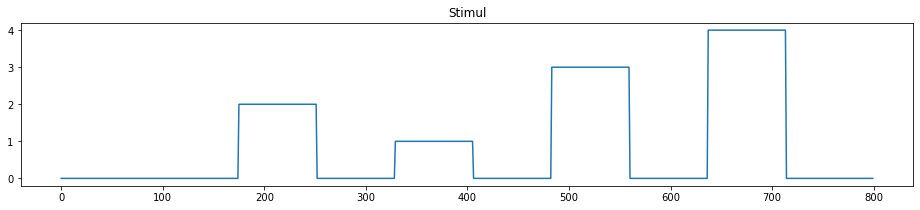

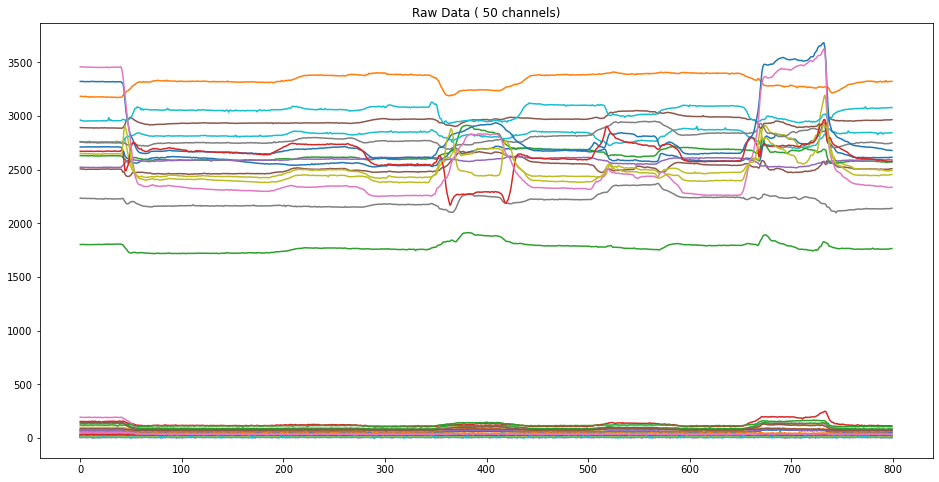

In [5]:
X_train_1 = np.swapaxes(np.load('Data/X_train_1.npy'),0,1) # меняю местами ось времени и номера каналов
print('Train 1 shape:', X_train_1.shape)
y_train_1 = np.load('Data/y_train_1.npy')
print('Target 1 shape:', y_train_1.shape)
print('Min target', y_train_1.min())
plot_train_target(X_train_1, y_train_1, 0,800)

По аналогии с предыдущими задачами проанализирую МО и СКО сигналов в каналах. СКО буду сразу анализировать как % от максимальной амлитуды в канале. 

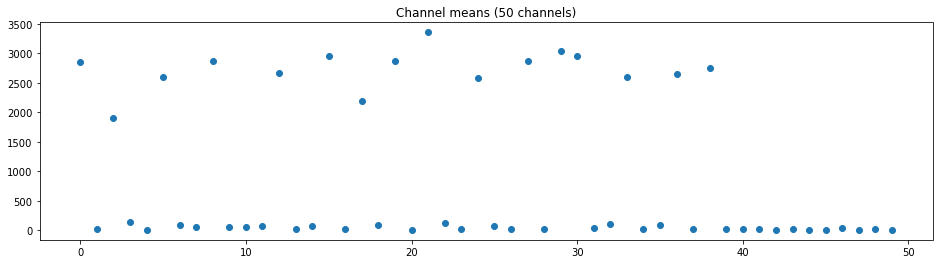

16 significant channels
(34,) [ 1  3  4  6  7  9 10 11 13 14 16 18 20 22 23 25 26 28 31 32 34 35 37 39
 40 41 42 43 44 45 46 47 48 49]
new shape: (16, 24030)


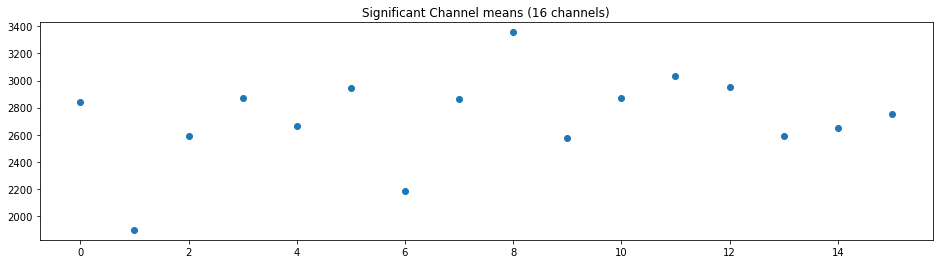

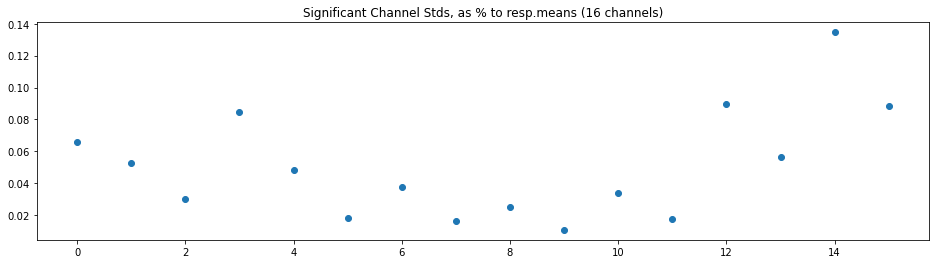

Low five channel std values 0.01081139576796149 0.016401997628571963 0.017899678119934932 0.018014123986187652 0.025114360283493207


In [6]:
plot_train_stat(X_train_1)

Сигналы в канале по среднему разделяются на две большие группы. Каналы с большим средним буду предполагать значимыми, а каналы с малым средним удалю.  Анализ по СКО особых инсайтов относительно данных не принес. 

В ходе работы над проектом возникло понимание необходимости анализа гистограммы распределения сигналов в каналах. 

Shape of significant channels (16, 24030)


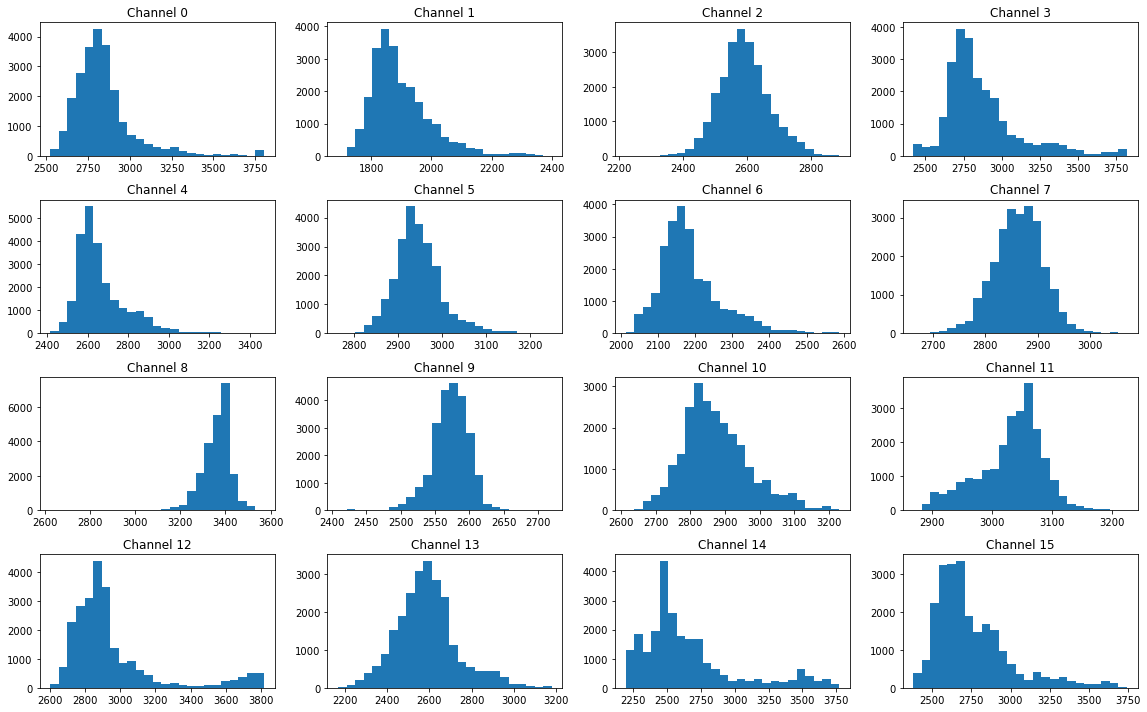

In [7]:
MIN_MEAN = 500
X_sign_train_1, _ = delete_low_sens(X_train_1, min_mean=MIN_MEAN, verbose=False)
print('Shape of significant channels', X_sign_train_1.shape)

fig, axx = plt.subplots(4, 4, figsize=(16, 10))

for i in range(4): 
    for j in range(4):
        chan = 4*i + j
        axx[i,j].hist(X_sign_train_1[chan],bins=25)
        axx[i,j].set_title(f'Channel {chan}')
plt.tight_layout()
plt.show();

В ходе работы над решением я обрнаружил, что параметры распределений сигнала по одному субъекту в исходных данных и на тесте не очень совпадают.  Минимумы на тесте меньше минимумов в исходных данных. Так может быть, например в случае, если примеры для теста нарезались из не предоставленного фрагмента исходных данных.  
Изучение литературы показало, что в случае нейронных сетей часто используют "стандартизацию" исходных данных - медиана -> 0, СКО -> 1.  Более сложная трансформация исходных данных подразумевает изменение распределения в входного сигнала с помощью PowerTransformer из пакета sklearn. В данном случае все исходные данные больше нуля, так что можно использовать Box-Cox трансформацию. 


Посмотрю на огибающую производной (сумму модулей первых производных) в значимых каналах. 

In [8]:
def diff_and_filter(data, thr):
    '''
    дифференцирование data и фильтрация шумов по уровню thr
    пропускаются (не обнуляются) только значения отсчетов выше уровня thr
    '''
    ddata = np.diff(data)
    return np.where(np.abs(ddata)<thr,0,ddata)

In [9]:
def make_envelope(data, thr=1, span=0, verbose=False ):
    '''
    Создание огибающей первой производной входных сигналов
    data - исходные данные 
    thr - уровень фильтрации исходного сигнала (необнуления первой производной)
    span -  минимальная ширина импульса команды - параметр на будущее
    verbose - вывод на печать справочной информации
    '''
    # min_mean = 500
    # if verbose : print('Original shape', train.shape)
    # data, _ = delete_low_sens(train, min_mean=min_mean, verbose=verbose)
    if verbose : print('Good Channel shape', data.shape)
    diff_data = diff_and_filter(data,thr)
    if verbose : print('Diff data shape', diff_data.shape)
    envelope = np.apply_along_axis((lambda x: (np.abs(x)).sum()), 0, diff_data )
    if verbose : print('Envelope shape', envelope.shape)
    return envelope

In [10]:
def plot_line(line, xmin, xmax, title='Title'):
    '''
    рисование одной линии на графике в диапазоне от xmin до xmax
    '''
    plt.figure(figsize=(16,4))
    plt.title(title)
    plt.plot(np.arange(xmin,xmax),line[xmin:xmax])
    plt.show();

In [11]:
def plot_two_lines(line1, line2, xmin, xmax, title1, title2):
    '''
    рисование двух линий на двух графиках в диапазоне от xmin до xmax
    '''
    gr_x = np.arange(xmin,xmax)
    fig, axs = plt.subplots(2, figsize=(16,8))
    axs[0].set_title(title1)
    axs[0].plot(gr_x,line1[xmin:xmax])

    axs[1].set_title(title2)
    axs[1].plot(gr_x,line2[xmin:xmax])
    plt.show();

In [12]:
def plot_three_lines(line1,line2,line3, xmin, xmax, title1, title2, title3):
    '''
    построение трех графиков в диапазоне от xmin до xmax
    line2 может быть набором линий
    '''
    gr_x = np.arange(xmin,xmax)
    fig, axs = plt.subplots(3, figsize=(16,12))
    #fig.suptitle('Дифференцирование сигналов с датчиков, cэмпл ' +  str(g))
    axs[0].set_title(title1)
    axs[0].plot(gr_x,line1[xmin:xmax])
    
    nc = line2.shape[0]
    axs[1].set_title(title2+' ('+str(nc)+' каналов)')
    for c in range(nc):
        axs[1].plot(gr_x,line2[c,xmin:xmax])

    axs[2].set_title(title3)
    axs[2].plot(gr_x,line3[xmin:xmax])
    plt.show();    

In [13]:
def plot_channels(data, xmin, xmax, title1):
    '''
    вывод на график сигналов в каналах в диапазоне xmin - xmax
    '''
    gr_x = np.arange(xmin, xmax)
    nc = data.shape[0]
    plt.figure(figsize=(16,5))
    plt.title(title1+' ('+str(nc)+' каналов)')
    for c in range(nc):
        plt.plot(gr_x,data[c,xmin:xmax])
    plt.show();

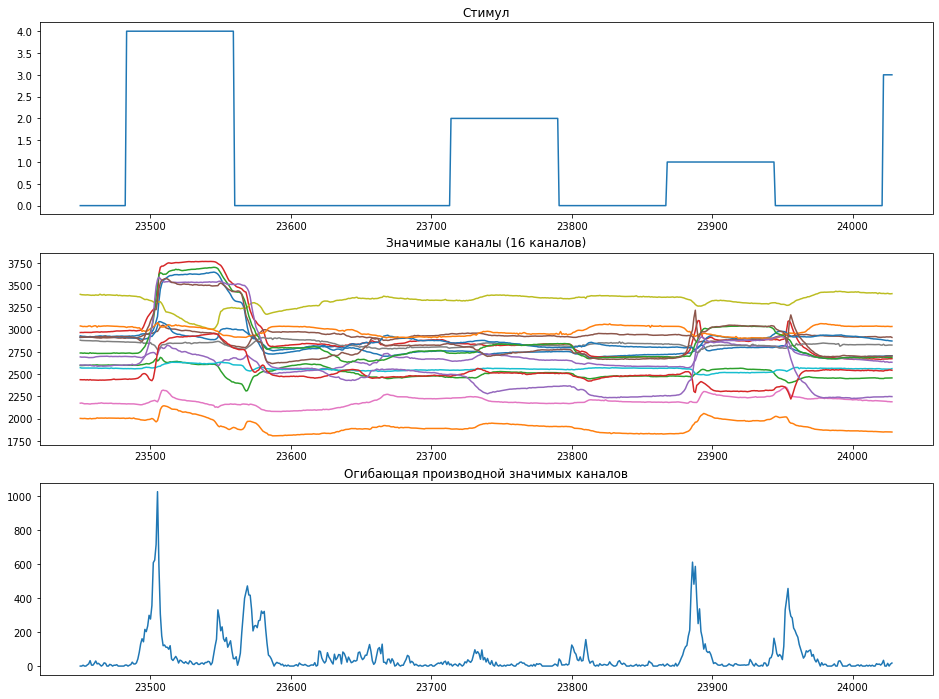

In [14]:
# В прошлой задаче уровень фильтрации был равен 20
good_data, _ = delete_low_sens(X_train_1, min_mean=500, verbose=False) 
envelope_1 = make_envelope(good_data, thr=5, verbose=False)
# plot_line(envelope_1,0,800,'Огибающая производной значимых каналов')
# 600,800
plot_three_lines(y_train_1,good_data,envelope_1,23450,24029,'Стимул', 'Значимые каналы', 'Огибающая производной значимых каналов')


Первая же попытка получить сигнал для детектирования моментов совершения команд показала необходимость дополнительных исследований.  Проблема в том, что человек может выполнить движение, не являющееся распознаваемым жестом - например повернуть кисть вокруг оси не разжимая или не сжимая ее. Также могут иметь место случайные флукутации плотности. При этом возникают изменения в каналах высокого уровня, они могут иметь достаточно большую амплитуду и восприниматься как значимый сигнал.  Необходимо провести нормализацию потенциалов в каждом значимом канале - отмасштабировать его в диапазон 0..1, соответствующий минимальному и макисмальному значению в канале. 

In [15]:
def scale_good_channels(data):
    '''
    масштабирование сигналов в каналах в диапазон 0..1 и 
    возвращает отмасштабированных данных и коэффициенты масштабирования
    коэфф-масштабирования: 
    0 - вычитаемое, немасштабированное
    1 - делитель масштаба
    '''
    num_sens = data.shape[0]
    # print(num_sens)
    # print(data.shape)
    scale = np.zeros((num_sens,2))
    sdata = np.zeros((data.shape[0],data.shape[1]))
    for s in range(num_sens):
        xmin = data[s,:].min()
        fact = 1/(data[s,:].max() - xmin)
        scale[s,0] = xmin
        scale[s,1] = fact
        # print(s, scale[s,0], scale[s,1])
        sdata[s,:] = data[s,:] - xmin
        sdata[s,:] = sdata[s,:] * fact
    return sdata, scale
    

In [16]:
def scale_channels_with_scale(data, scale):
    '''
    масштабирует данные в каналах массива data с помощью коэффициентов scale
    возвращает отмасштабированные данные
    '''
    num_sens = data.shape[0]
    sdata = np.zeros((data.shape[0],data.shape[1]))
    for s in range(num_sens):
        xmin =  scale[s,0]
        fact = scale[s,1] 
        # print(s, scale[s,0], scale[s,1])
        sdata[s,:] = data[s,:] - xmin
        sdata[s,:] = sdata[s,:] * fact
    return sdata

In [17]:
def ewma(data,window):
    '''
    экспоненциальное сглаживание data в окне window
    '''
    alpha = 2 /(window+1.0)
    new_data = data * alpha
    new_data[0] = data[0] # первое значение равно первому значению исходных данных
    for r in range(1,data.shape[0]):
        new_data[r] += new_data[r-1] * (1-alpha)
    return new_data

In [18]:
def calc_smooth_env(train, min_mean, src_w, env_w, low_l): 
    '''
    расчет сглаженных сигналов в каналах и сглаженной огибающей
    train - обучающие данные для удаления несущественных каналов
    min_mean - минимальное среднее канала для его удаления
    src_w - окно для сглаживания исходных данных
    env_w - окно для сглаживания огибающей
    low_l - нижний порог пропускания фильтра
    возвращает:
    swooth_data - сглаженные масштабированные данные в значимых каналах
    smooth_env - селженная огибающая производной
    del_chan - каналы для удаления
    scale - масштаб в оставшихся значимых каналах
    '''
    good_data,  del_chan = delete_low_sens(train, min_mean=min_mean, verbose=False) 
    scaled_data, scale = scale_good_channels(good_data)
    smooth_data = np.apply_along_axis(ewma, 1, scaled_data, src_w)
    envelope = make_envelope(smooth_data, thr=low_l, verbose=False)
    smooth_env = ewma(envelope, env_w)
    return smooth_data, smooth_env, del_chan, scale 


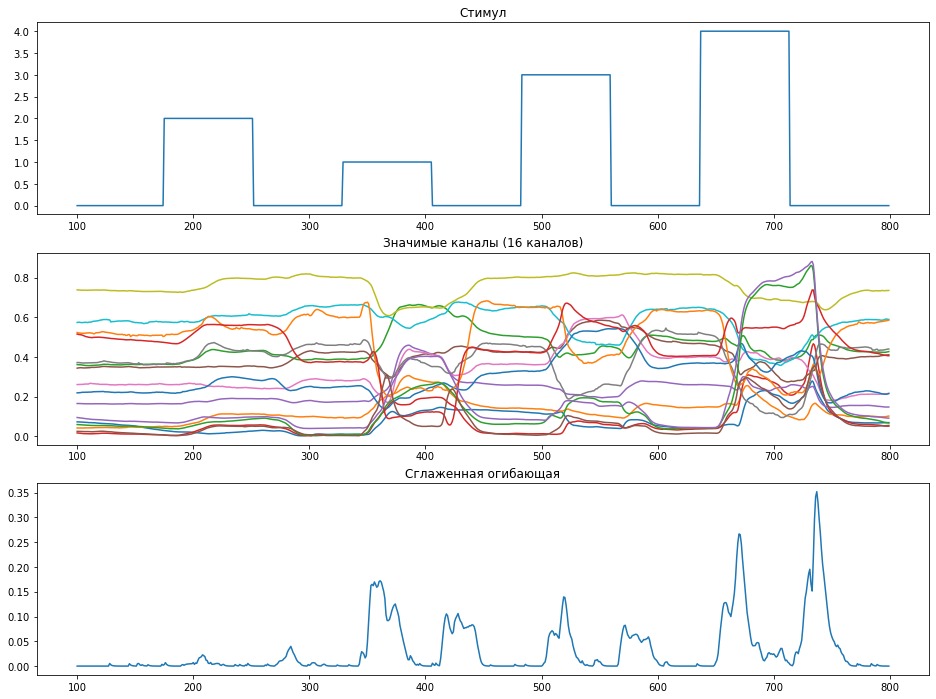

In [19]:
MIN_MEAN = 500    # минимальное среднее для пороговой фильтрации
SRC_WINDOW = 8    # размер окна для экспоненциального сглаживания исходных данных
ENV_WINDOW = 3    # размер окна для эксп.сглаживания огибающей
LOW_LIMIT = 0.004  # нижний порог пропускания фильтра

smooth_data_1, smooth_env_1, del_chan_1, scale_1 = calc_smooth_env(X_train_1, MIN_MEAN, SRC_WINDOW, ENV_WINDOW, LOW_LIMIT)
# plot_line(envelope_1,0,800,'Огибающая производной значимых каналов')
# 600,800
plot_three_lines(y_train_1,smooth_data_1,smooth_env_1,100,800,
                'Стимул', 'Значимые каналы', 'Сглаженная огибающая')


Результаты двойной экспоненциальной фильтрации выглядят привлекательно.  Попробую сопоставить первую производную стимула и огибающую.  

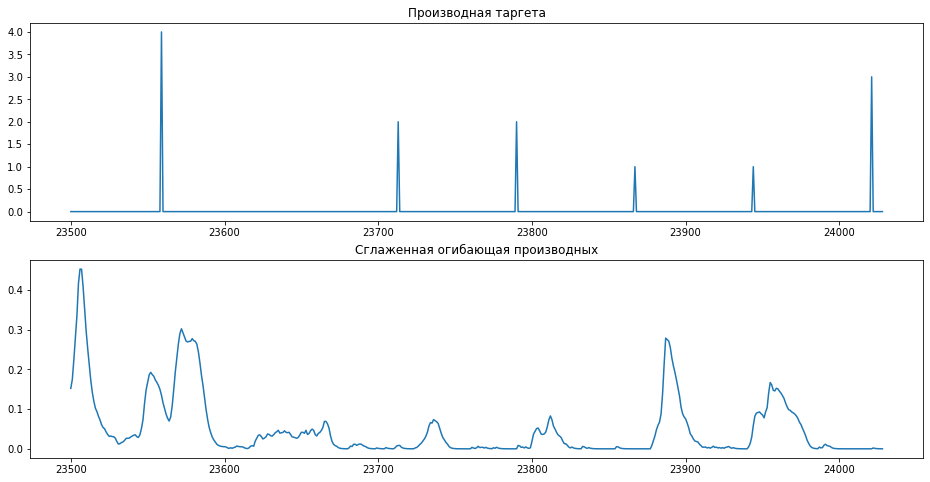

In [20]:
diff_targ_1 = np.abs(np.diff(y_train_1))
plot_two_lines(diff_targ_1, smooth_env_1, 23500, 24029, 'Производная таргета', 'Сглаженная огибающая производных')

In [21]:
def get_switch_pos(diff_targ, env):
    '''
    поиск позций подачи комад в сглаженной огибающей
    возвращает
    0 - момент подачи команды в таргете
    1 - момент подачи команды субъектом
    2 - задержка 1 относительно 2
    3 - значение пика сглаженой огибающей на момент команды 
    '''
    diff_pos = np.flatnonzero(diff_targ>0)
    act_pos = np.zeros_like(diff_pos)
    act_delay = np.zeros_like(diff_pos)
    act_val = np.zeros((diff_pos.shape[0]))
    maxpos = env.shape[0]
    maxcmd = diff_pos.shape[0]
    for cmd in range(maxcmd): 
        p0 = diff_pos[cmd]
        p1 = ((diff_pos[cmd]+ 50) if cmd < maxcmd-1 else maxpos) #diff_pos[cmd+1] if cmd < maxcmd-1 else maxpos
        frame = env[p0:p1]
        act_val[cmd] = frame.max()
        act_delay[cmd] = np.argmax(frame)
        act_pos[cmd] = p0 + act_delay[cmd]
    # print(p0,p1,act_pos[cmd], act_delay[cmd], act_val[cmd])
    return diff_pos, act_pos, act_delay, act_val

In [22]:
def plot_two_hist(title1, data1, title2, data2):
    '''
    построение двух гистограмм по данным data1 и data2
    '''
    fig, axx = plt.subplots(1,2, figsize=(16,5))
    axx[0].hist(data1, bins = 25) 
    axx[0].set_title(title1)
    
    axx[1].hist(data2, bins = 25) 
    axx[1].set_title(title2)
    plt.show();

    print(title1, ', квартили распределения',np.quantile(data1, q=[0.25,0.5,0.75]))
    print(title2, ', квартили распределения',np.quantile(data2, q=[0.25,0.5,0.75]))

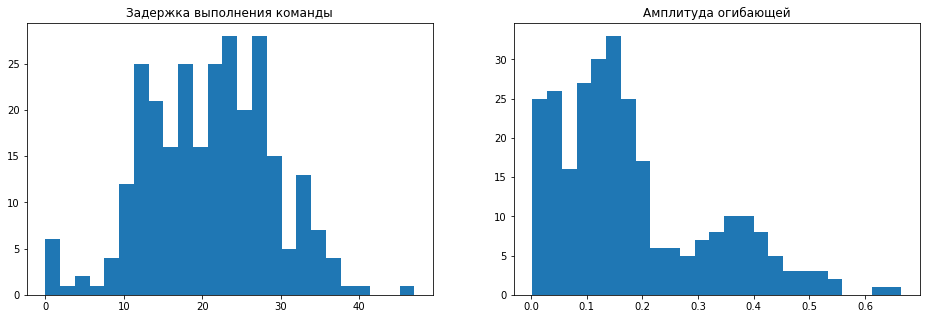

Задержка выполнения команды , квартили распределения [15. 22. 27.]
Амплитуда огибающей , квартили распределения [0.0824005  0.1429254  0.25382646]


In [23]:
diff_pos, actual_pos, actual_delay, actual_value = get_switch_pos(diff_targ_1, smooth_env_1 )
plot_two_hist('Задержка выполнения команды', actual_delay, 'Амплитуда огибающей', actual_value)

Команды компьютера оператор выполняет обычно с задержкой - порядка 0.6 сек. Задержка необходима на распознавание и осознание поданной команды. Однако человек быстро выучивает однотипные манипуляции. Можно предположить, что малая задержка (по факту была и отрицательная задержка (опережение) в диапазоне до 0.3 сек) вызвана быстрым выучиванием протокола.  

In [24]:
def calc_distances(time_serie):
    '''
    расчет дистанции между двумя соседними командами
    '''
    serie_size = time_serie.shape[0]-1
    dist = np.zeros((serie_size))
    for p in range(serie_size):
        dist[p] = time_serie[p+1]-time_serie[p]
    return dist

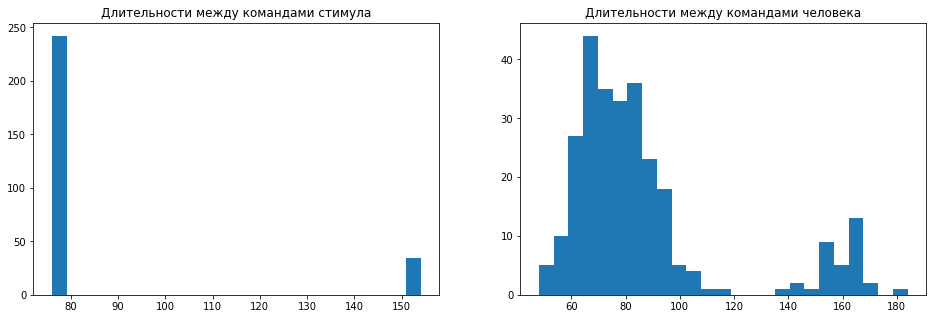

Длительности между командами стимула , квартили распределения [77. 77. 77.]
Длительности между командами человека , квартили распределения [67.   77.   89.25]


In [25]:
command_dist = calc_distances(diff_pos) #рефрактерные периоды таргета
actual_distance = calc_distances(actual_pos)
plot_two_hist('Длительности между командами стимула', command_dist,'Длительности между командами человека', actual_distance)

Компьютер подавал команды через фиксированное время. Были и паузы двойной длительности. 

Протокол измерений сигналов датчиков подразумевает подачу команды и возврат к открытой руке.  По видимому человек успевает выучить что после команды какого то жеста идет возврат в исходное положение открытой ладони и начинает совершать соответствующие действия быстрее, чем осознает команду на открывание ладони, поданную ему компьютером. Отсюда меньшие задержки исполнения команды раскрытия и смешение длительности между командами влево.  

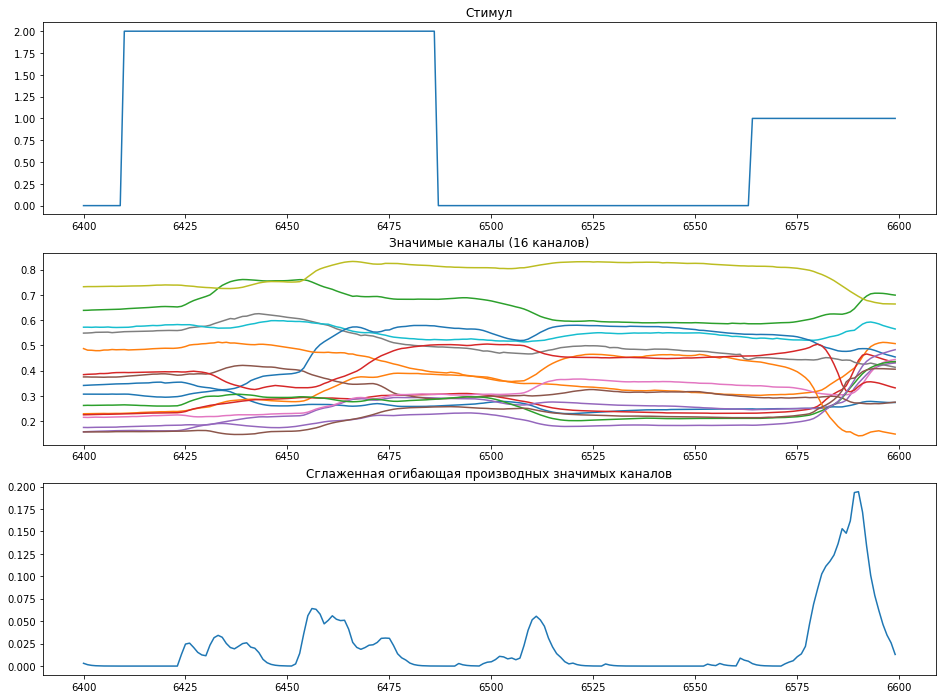

In [26]:
plot_three_lines(y_train_1, smooth_data_1, smooth_env_1, 6400,6600,
                'Стимул', 'Значимые каналы', 'Сглаженная огибающая производных значимых каналов')


Выше пример шевеления кистью в промежутке между исполнением двух команд компьютера. Локальный максимум нераспознаваемого шевеления выше локальных максимумов распознаваемых команд, что создает дополнительные сложности простым алгоритмам поиска момента команды. 

#### Исходные данные Субъекта 2

Train 2 shape: (50, 23202)
Target 2 shape: (23202,)
Min target -1


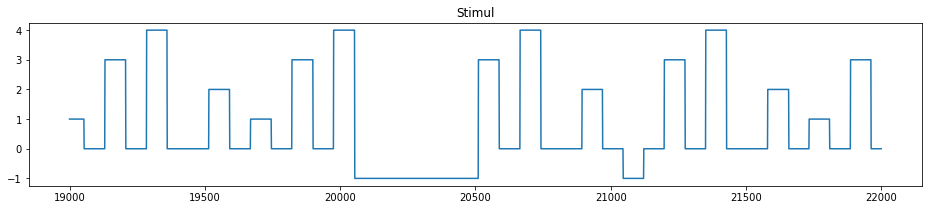

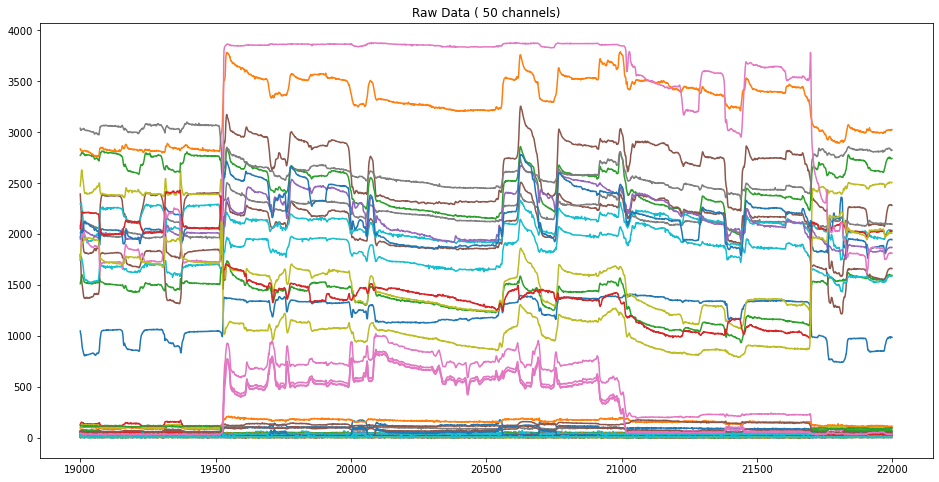

In [27]:
X_train_2 = np.swapaxes(np.load('Data/X_train_2.npy'),0,1)
print('Train 2 shape:', X_train_2.shape)
y_train_2 = np.load('Data/y_train_2.npy')
print('Target 2 shape:', y_train_2.shape)
print('Min target', y_train_2.min())
plot_train_target(X_train_2, y_train_2, 19000, 22000)  # 12500 13900

По замечанию организаторов target=-1 обозначает выбросы в исходных данных, которые подлежат удалению. Для Субъекта 2 характерно повышение плотности в каналах, которые для субъекта 1 были незначимыми. 

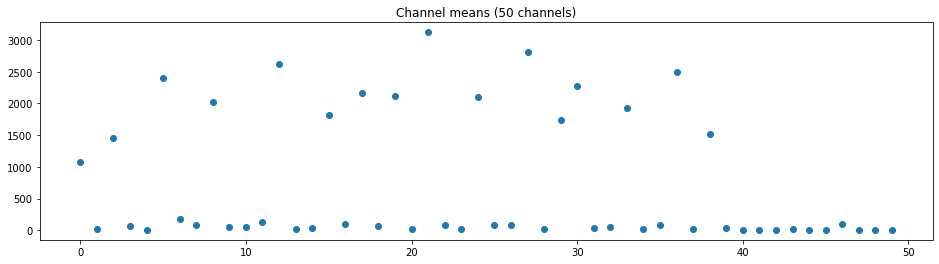

16 significant channels
(34,) [ 1  3  4  6  7  9 10 11 13 14 16 18 20 22 23 25 26 28 31 32 34 35 37 39
 40 41 42 43 44 45 46 47 48 49]
new shape: (16, 23202)


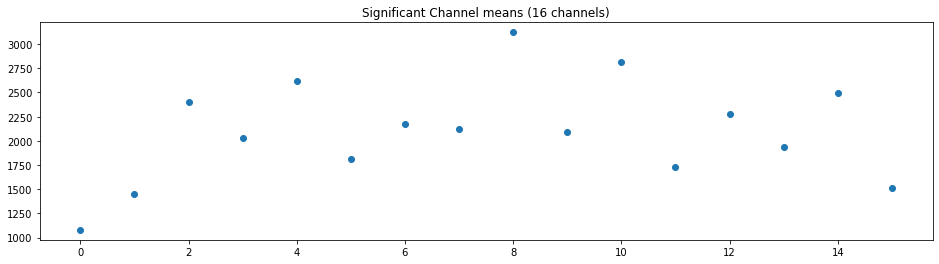

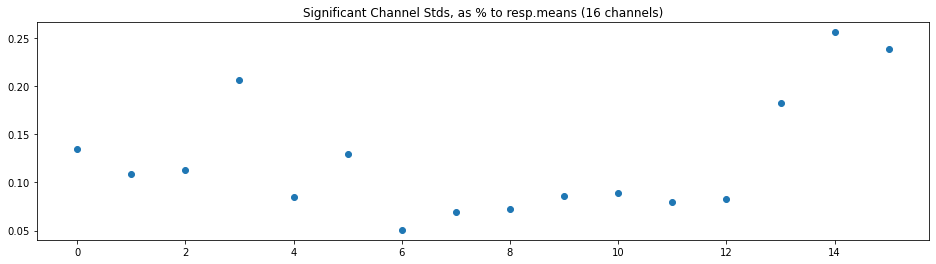

Low five channel std values 0.0507418961673332 0.06940008657119377 0.07274480149615076 0.07987890029539425 0.08276431247369655


In [28]:
plot_train_stat(X_train_2)

Удаление незначимых каналов по низкому среднему обеспечивает то же количество значимых каналов, что может свидетельствовать об устойчивости гипотезы. 

СКО "самых неизменных" сигналов сенсоров в случае наблюдения за другим добровольцем больше в пять раз первого случая. Наверное не нужно удалять сигналы с "самых неизменных" сенсоров.  

Shape of significant channels (16, 23202)


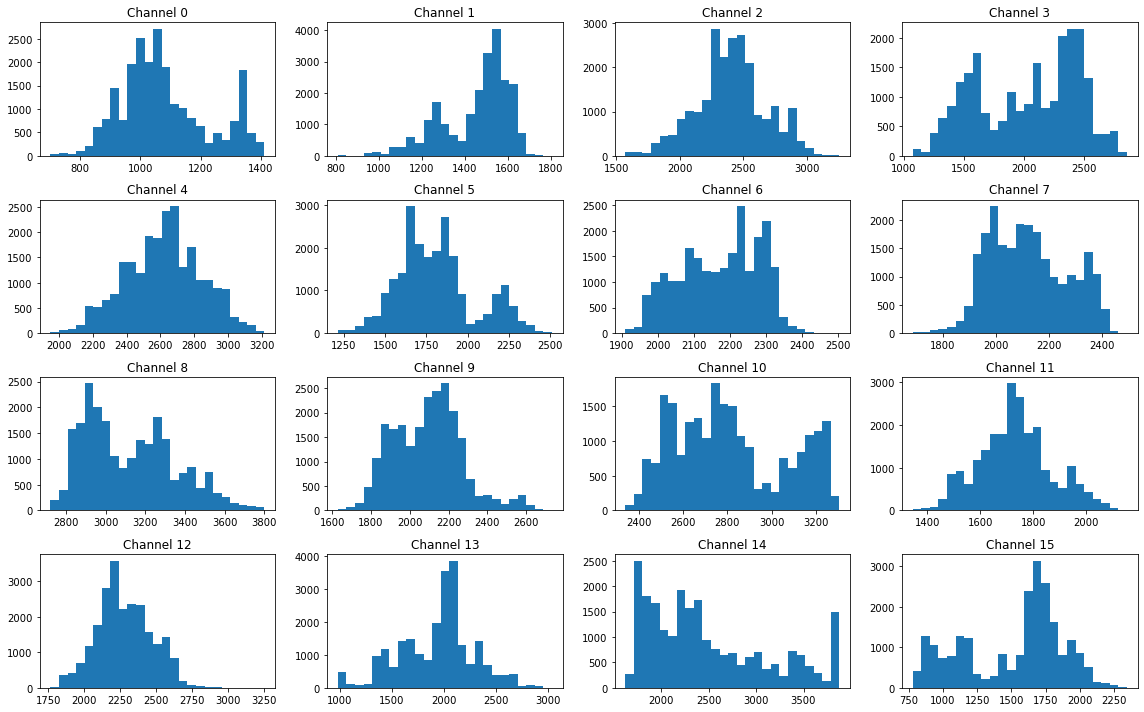

In [29]:
X_sign_train_2, _ = delete_low_sens(X_train_2, min_mean=MIN_MEAN, verbose=False)
print('Shape of significant channels', X_sign_train_2.shape)

fig, axx = plt.subplots(4, 4, figsize=(16, 10))

for i in range(4): 
    for j in range(4):
        chan = 4*i + j
        axx[i,j].hist(X_sign_train_2[chan],bins=25)
        axx[i,j].set_title(f'Channel {chan}')
plt.tight_layout()
plt.show();

По гистограммам Субъекта 2 заметно, что все гистограммы левее (ниже по уровню) и шире. Потенциально это может быть проблемой для распознавания. 

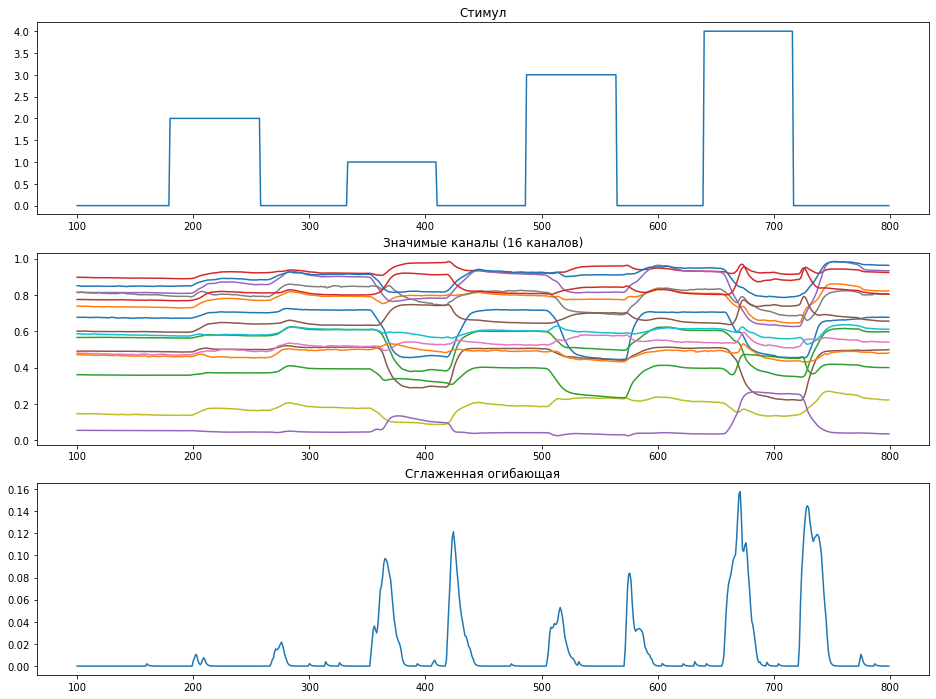

In [30]:
smooth_data_2, smooth_env_2, del_chan_2, scale_2 = calc_smooth_env(X_train_2, MIN_MEAN, SRC_WINDOW, ENV_WINDOW, LOW_LIMIT)
# plot_line(envelope_1,0,800,'Огибающая производной значимых каналов')
# 600,800
plot_three_lines(y_train_2,smooth_data_2,smooth_env_2,100,800,
                'Стимул', 'Значимые каналы', 'Сглаженная огибающая')


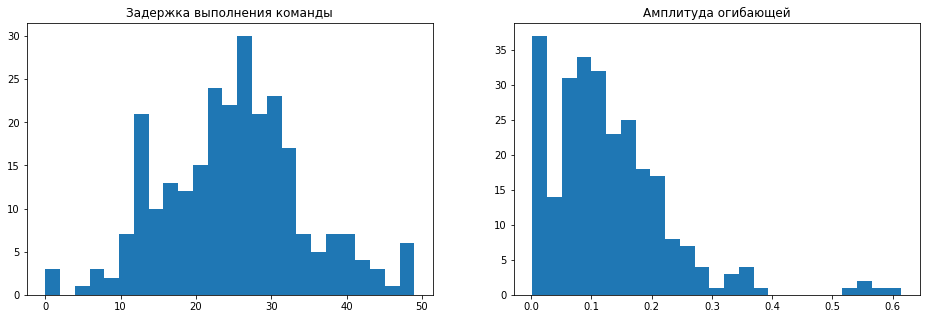

Задержка выполнения команды , квартили распределения [18. 25. 31.]
Амплитуда огибающей , квартили распределения [0.05968935 0.11176303 0.17485396]


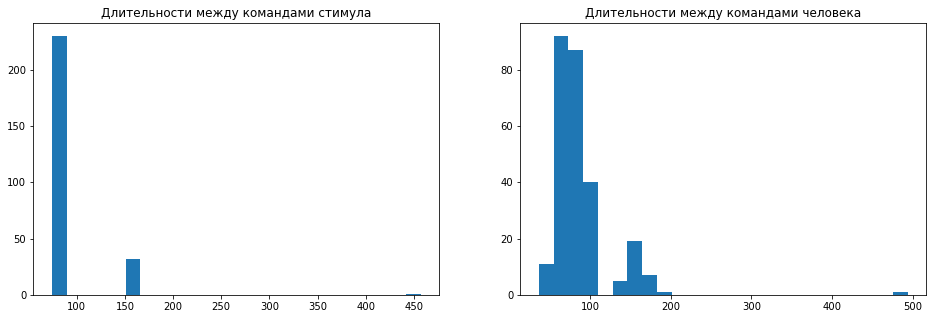

Длительности между командами стимула , квартили распределения [76. 77. 77.]
Длительности между командами человека , квартили распределения [66.5 78.  91. ]


In [31]:
diff_targ_2 = np.abs(np.diff(y_train_2))
diff_pos, actual_pos, actual_delay, actual_value = get_switch_pos(diff_targ_2, smooth_env_2 )
plot_two_hist('Задержка выполнения команды', actual_delay, 'Амплитуда огибающей', actual_value)
command_dist = calc_distances(diff_pos) #рефрактерные периоды таргета
actual_distance = calc_distances(actual_pos)
plot_two_hist('Длительности между командами стимула', command_dist,'Длительности между командами человека', actual_distance)

Похоже, что Субъект чуть медленнее реагировал на стимул компьютреа и сигналы с датчиков поменьше уровнем. Стоит заметить, что я не удалял плохие данные в случае Субъекта 2 и после их удаления картина может слегка измениться. 
 

#### Иссходные данные Субъекта 3

Train 3 shape: (50, 23177)
Target 3 shape: (23177,)
Min target 0


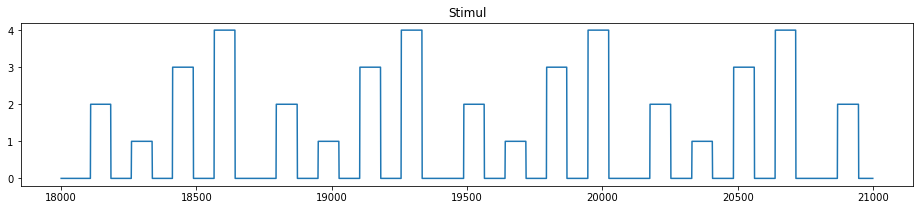

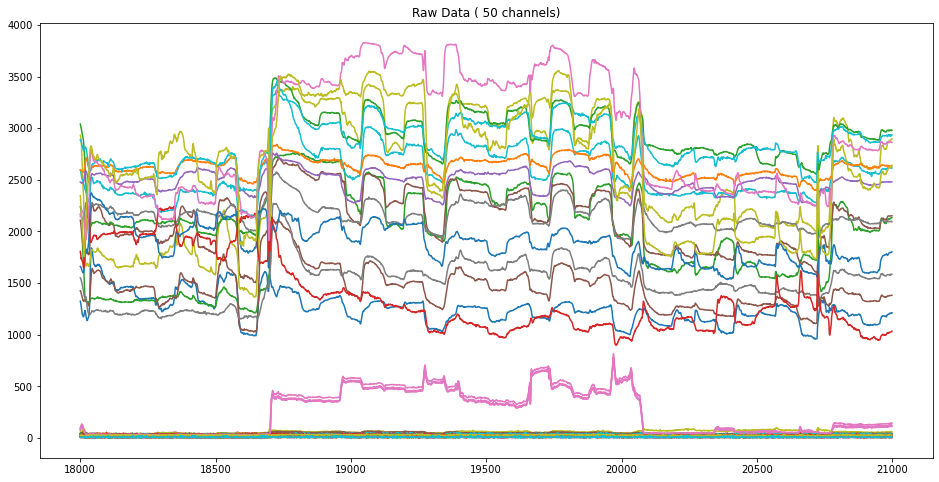

In [32]:
X_train_3 = np.swapaxes(np.load('Data/X_train_3.npy'),0,1)
print('Train 3 shape:', X_train_3.shape)
y_train_3 = np.load('Data/y_train_3.npy')
print('Target 3 shape:', y_train_3.shape)
print('Min target', y_train_3.min())
plot_train_target(X_train_3, y_train_3, 18000, 21000)

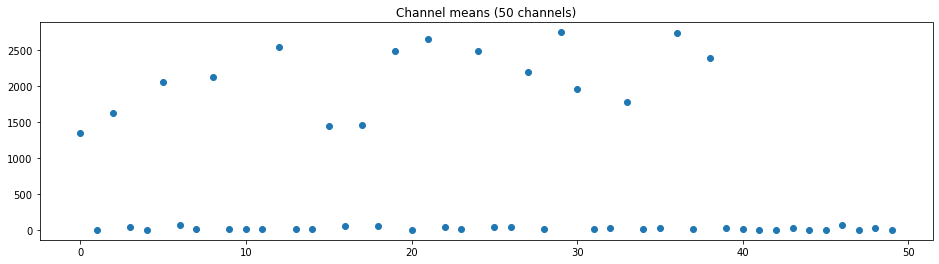

16 significant channels
(34,) [ 1  3  4  6  7  9 10 11 13 14 16 18 20 22 23 25 26 28 31 32 34 35 37 39
 40 41 42 43 44 45 46 47 48 49]
new shape: (16, 23177)


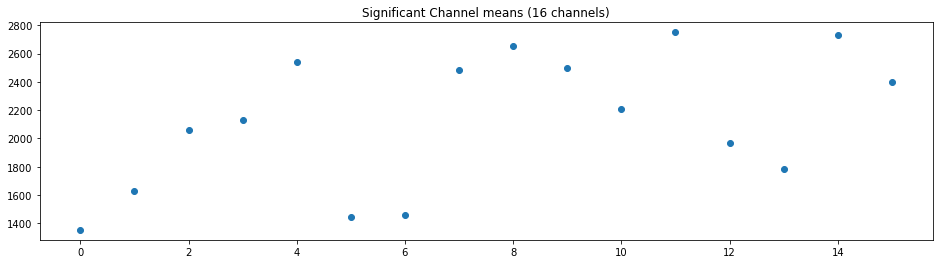

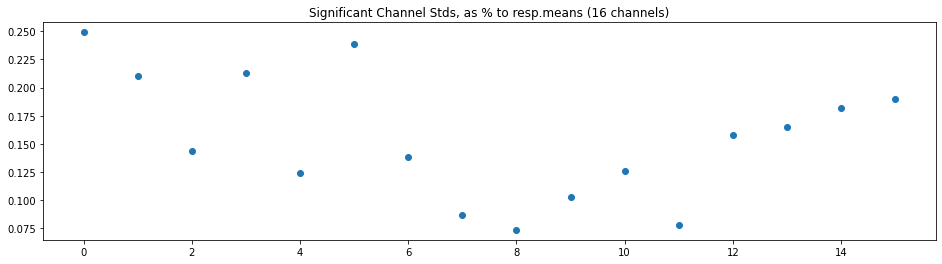

Low five channel std values 0.07331983892367573 0.07773594048292191 0.08653928743531038 0.10288810065785196 0.124216669654035


In [33]:
plot_train_stat(X_train_3)

Shape of significant channels (16, 23177)


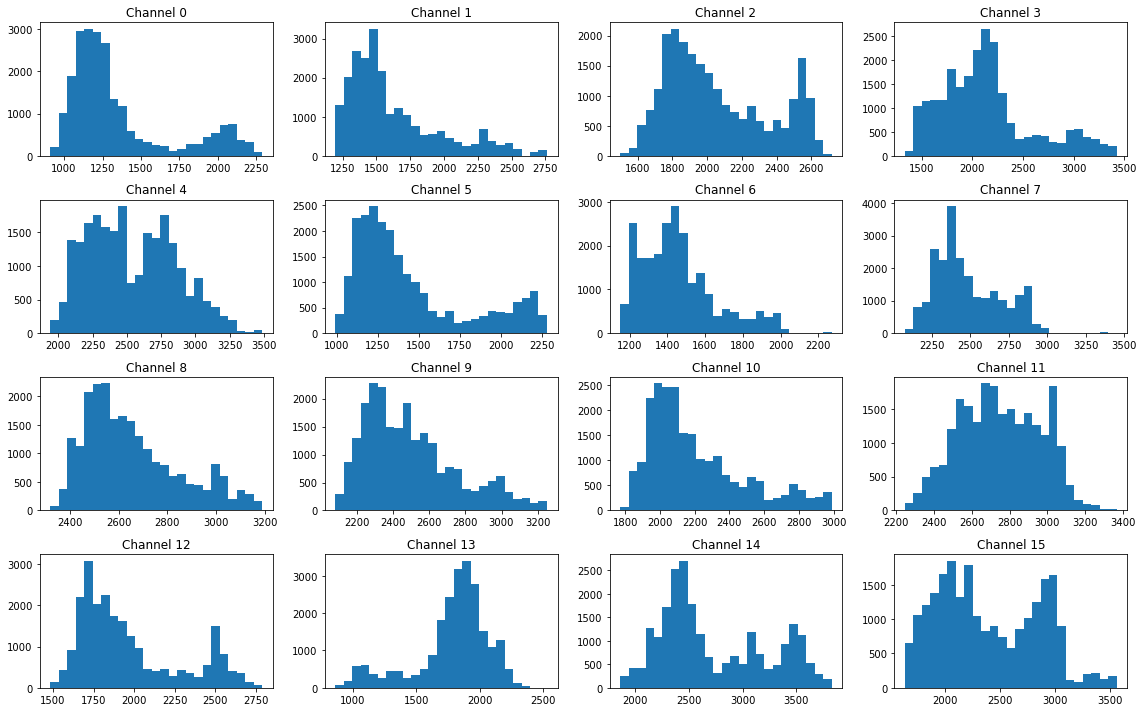

In [34]:
X_sign_train_3, _ = delete_low_sens(X_train_3, min_mean=MIN_MEAN, verbose=False)
print('Shape of significant channels', X_sign_train_3.shape)

fig, axx = plt.subplots(4, 4, figsize=(16, 10))

for i in range(4): 
    for j in range(4):
        chan = 4*i + j
        axx[i,j].hist(X_sign_train_3[chan],bins=25)
        axx[i,j].set_title(f'Channel {chan}')
plt.tight_layout()
plt.show();

Гистограммы в случае субъекта 3 тоже более широкие. Визуально гистограммы Субъектов 2 и 3 сложно отнести к типу унимодальных. Они скорее бимодальные. В этой связи возможно скалирование распределения в сторону стандартного нормально является не лучшей стратегией. Правильно было бы сделать min-max нормализацию в той или иной форме. 

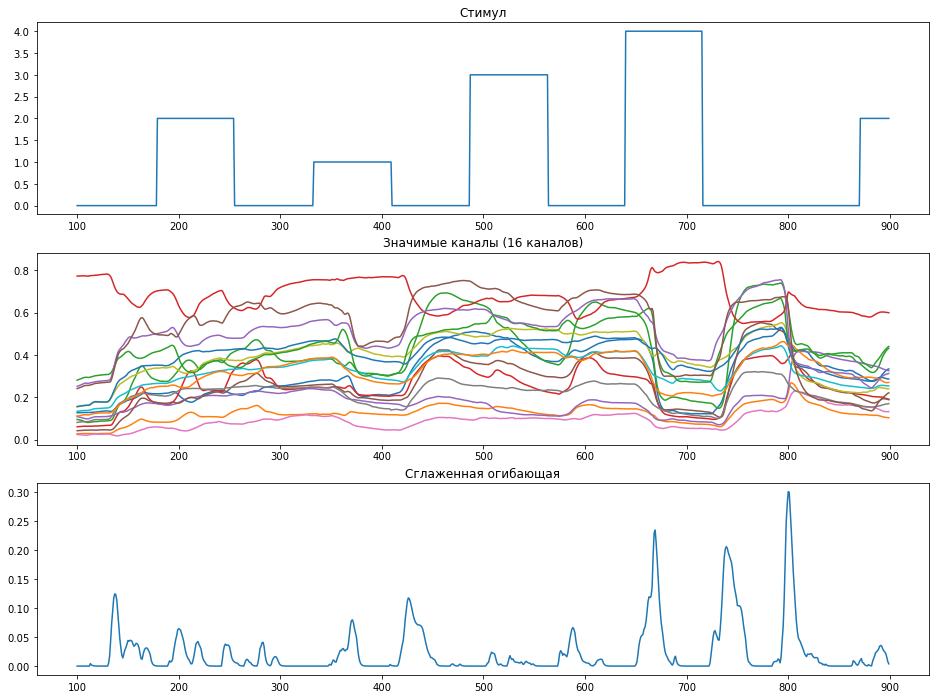

In [35]:
smooth_data_3, smooth_env_3, del_chan_3, scale_3 = calc_smooth_env(X_train_3, MIN_MEAN, SRC_WINDOW, ENV_WINDOW, LOW_LIMIT)
# plot_line(envelope_1,0,800,'Огибающая производной значимых каналов')
# 600,800
plot_three_lines(y_train_3,smooth_data_3,smooth_env_3,100,900,
                'Стимул', 'Значимые каналы', 'Сглаженная огибающая')


Ярко заметно бессодержательное изменение плотности, возможно вследствие шевеления рукой в районе 800 отсчета. 

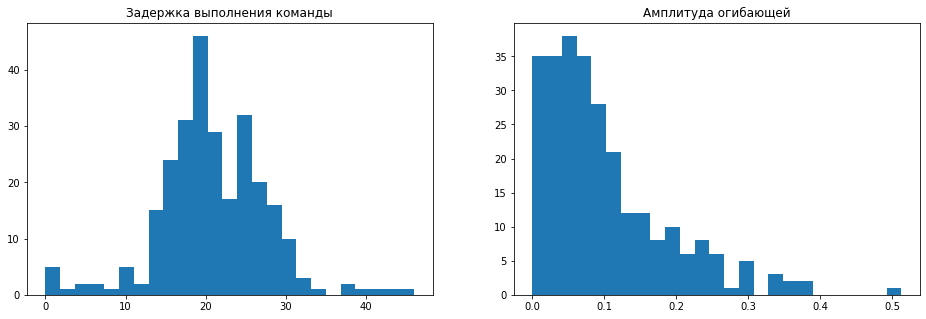

Задержка выполнения команды , квартили распределения [17.  20.5 25. ]
Амплитуда огибающей , квартили распределения [0.03933262 0.07363329 0.14082058]


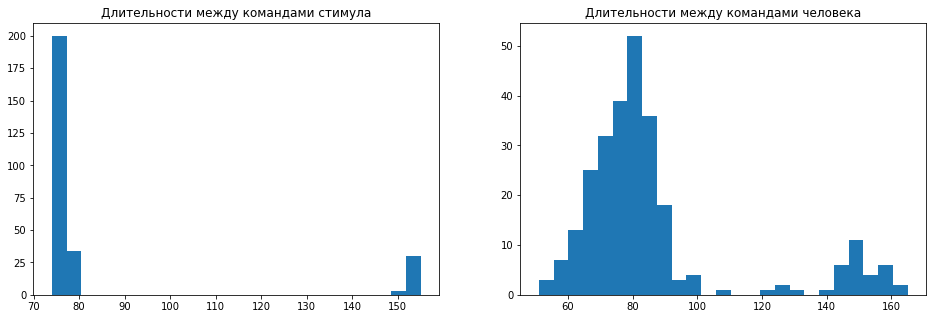

Длительности между командами стимула , квартили распределения [76.  77.  77.5]
Длительности между командами человека , квартили распределения [72. 79. 86.]


In [36]:
diff_targ_3 = np.abs(np.diff(y_train_3))
diff_pos, actual_pos, actual_delay, actual_value = get_switch_pos(diff_targ_3, smooth_env_3 )
plot_two_hist('Задержка выполнения команды', actual_delay, 'Амплитуда огибающей', actual_value)
command_dist = calc_distances(diff_pos) #рефрактерные периоды таргета
actual_distance = calc_distances(actual_pos)
plot_two_hist('Длительности между командами стимула', command_dist,'Длительности между командами человека', actual_distance)

Субъект 3 исполняет команды чуть побыстрее, но уровни огибающей в пиках у него ниже. 

По информации организаторов три набора исходных сырых данных сняты с трех разных добровольцев. Фактически предоставлены исходные данные, на основе которых необходимо сформировать обучающие данные для выбранных алгоритмов.

Замечания по исходным данным: 
- В исходных файлах данные записаны в формате (отсчеты, каналы) и отличаются от тестовых данных и привычного по прошлым задачам формата.  Порядок исправлен на момент загрузки данных. 
- Каналов (сенсоров) стало больше (50), но по прежнему много сигналов с уровнем меньше 1000, которые можно удалить;
- В нижней группе (под удаление) есть проблемные каналы, которые могут достигать по уровню рабочих сигналов, однако с распознаваемыми движениями не связаны, однако они имеют небольшую длительность и их можно отфильтровать по среднему уровню за весь период например >500;
- В наборе 2 есть участки с меткой -1, что означает потенциально битые данные. Эти участки кода необходимо просто удалить.

#### Тестовые данные

- Данные записаны в формате pkl ("маринад") и расшифровки организаторы не предоставили. 
- Три набора соответствуют трем субъектам, сигналы которых представлены в качестве сырых обучающих данных 
- Можно подобрать какие-то параметры под каждого человека и решать задачу классификации отдельно по каждому субъекту
- Тайм-фреймы отличаются длительностью. По словам организаторов - наборы могут быть при подготовке растянуты во времени для усложнения задачи распознавания. 

In [37]:
# чтение pkl файла и построение графиков на основе данных из него
def plot_test(test):
    '''
    рисование графиков тестовых данных
    test - надборы данных из "маринада"
    '''
    len1 = len(test)
    print('List of', len1, 'timeframes')
    pos = [ int(len1*np.random.random()), int(len1*np.random.random()), int(len1*np.random.random()) ]
    for p in pos:
        # print('Shape of array#', p, test[p].shape)
        gr_x = np.arange(0, test[p].shape[1]) 
        plt.figure(figsize=(16,5))
        plt.title('Test sample #'+str(p)+' ('+ str(test[p].shape[0]) +' channels, '+ str(test[p].shape[1])+ ' readouts)')
        for i in range(test[p].shape[0]): 
            plt.plot(gr_x,test[p][i,:])
    plt.show();
    # формирование гистограммы длительности тайм-фреймов в наборе
    test_lengths = [x.shape[1] for x in test] 
    #plt.figure(figsize=(16,4))
    #plt.title('Распределение длительностей таймфреймов')
    #plt.hist(test_lengths, bins=25)
    #plt.show();
    test_lengths = sorted(list(set(test_lengths)))
    print('Time Frame Lengts:', test_lengths)
    test_qty = dict()
    
    for x in test_lengths:
        test_qty[x] = 0
    for x in test:
        test_qty[x.shape[1]] += 1
    print('Test TimeFrame composition:', test_qty)

List of 899 timeframes


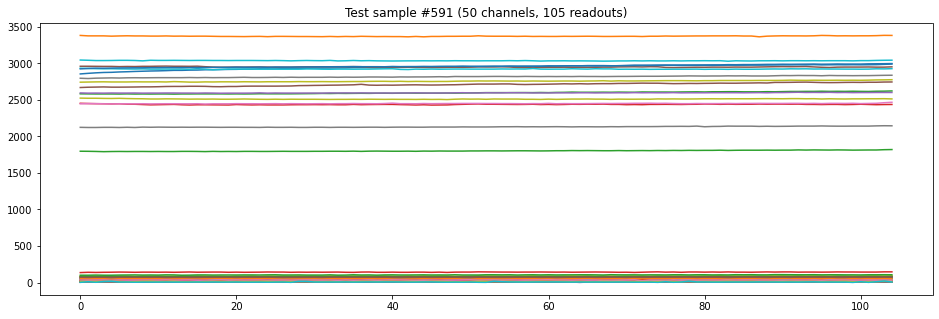

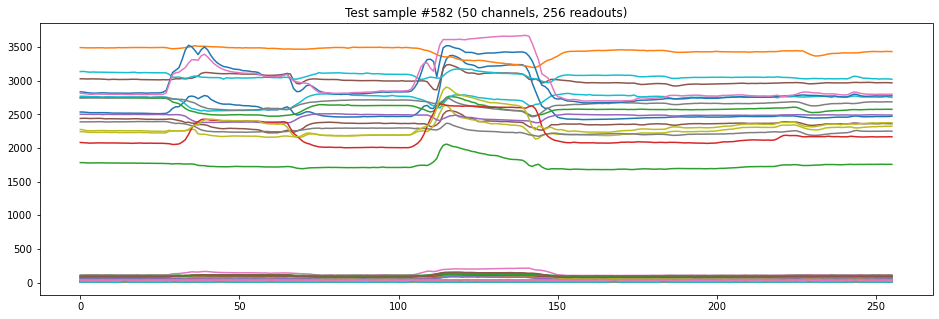

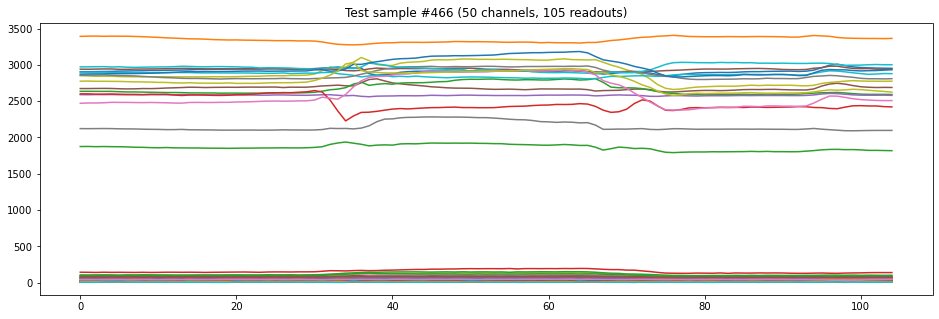

Time Frame Lengts: [105, 181, 256]
Test TimeFrame composition: {105: 303, 181: 299, 256: 297}


In [38]:
test_1 = pkl.load(open('Data/X_test_dataset_1.pkl', 'rb'))
plot_test(test_1)

В ходе построения задачи было замечено, что диапазоны изменения данных могут отличаться в исходных и тестовых данных в некоторых каналах. Проверю это.

In [39]:
test_array_1 = np.concatenate(tuple(test_1),axis=1)
min_test_1 = np.apply_along_axis(np.min, 1, test_array_1)
max_test_1 = np.apply_along_axis(np.max, 1, test_array_1)
min_train_1 = np.apply_along_axis(np.min, 1, X_train_1)
max_train_1 = np.apply_along_axis(np.max, 1, X_train_1 )


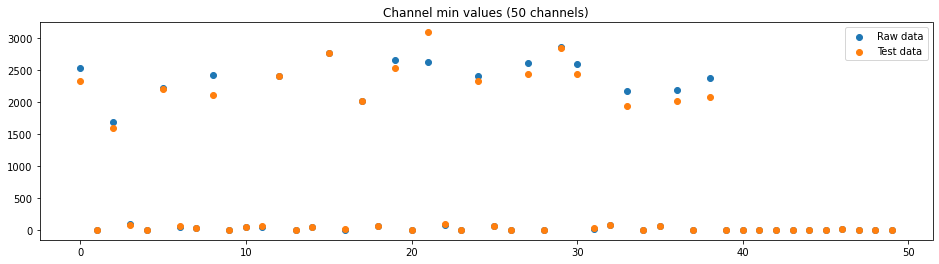

In [40]:
num_sens = X_train_1.shape[0]
plt.figure(figsize=(16,4))
plt.title('Channel min values (' + str(num_sens)+' channels)')
plt.scatter(np.arange(num_sens), min_train_1, label='Raw data')
plt.scatter(np.arange(num_sens), min_test_1, label='Test data')
plt.legend(loc='best')
plt.show();

In [41]:
test_train_ratio = min_test_1/min_train_1
test_train_ratio[test_train_ratio<1]

/var/folders/gb/vp2kjpjj7kxgkxk0ltq2p87h0000gn/T/ipykernel_60285/1743198111.py:1: RuntimeWarning: divide by zero encountered in divide
  test_train_ratio = min_test_1/min_train_1
/var/folders/gb/vp2kjpjj7kxgkxk0ltq2p87h0000gn/T/ipykernel_60285/1743198111.py:1: RuntimeWarning: invalid value encountered in divide
  test_train_ratio = min_test_1/min_train_1


array([0.9216152 , 0.9443787 , 0.73195876, 0.99279604, 0.87190083,
       0.25      , 0.99461698, 0.33333333, 0.99850969, 0.96610169,
       0.94892978, 0.96969697, 0.93494068, 0.99337748, 0.93925413,
       0.89760148, 0.98214286, 0.92290146, 0.87505259, 0.8       ])

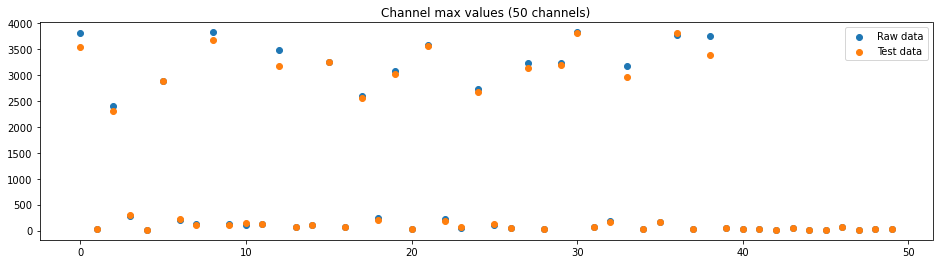

In [42]:
plt.figure(figsize=(16,4))
plt.title('Channel max values (' + str(num_sens)+' channels)')
plt.scatter(np.arange(num_sens), max_train_1, label='Raw data')
plt.scatter(np.arange(num_sens), max_test_1, label='Test data')
plt.legend(loc='best')
plt.show();

List of 855 timeframes


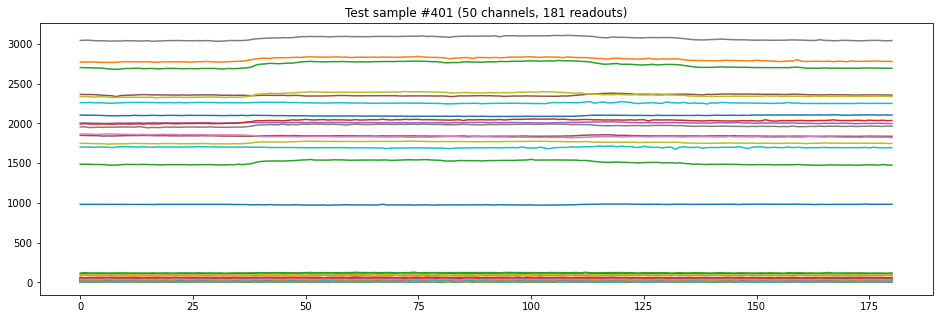

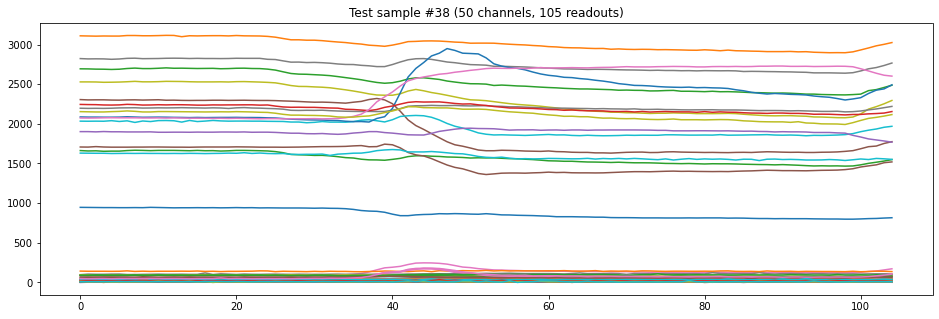

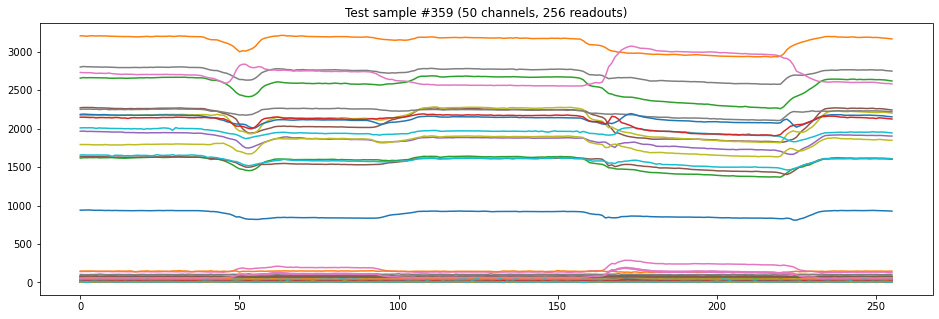

Time Frame Lengts: [105, 181, 256]
Test TimeFrame composition: {105: 286, 181: 285, 256: 284}


In [43]:
plot_test( pkl.load(open('Data/X_test_dataset_2.pkl', 'rb')))

List of 855 timeframes


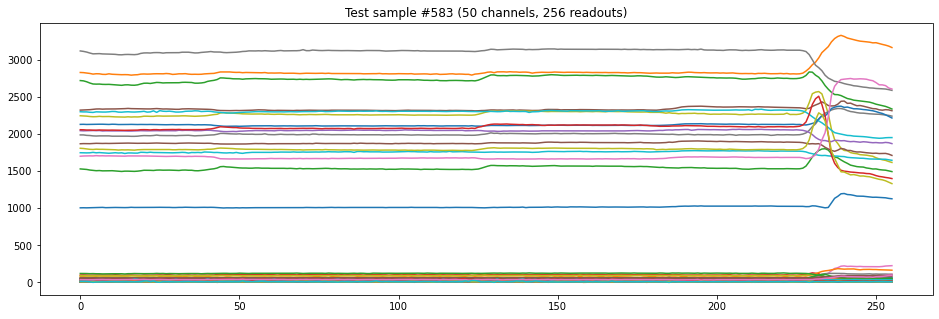

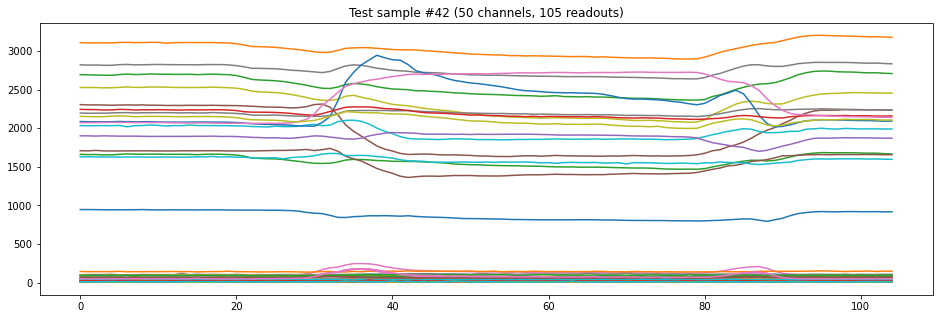

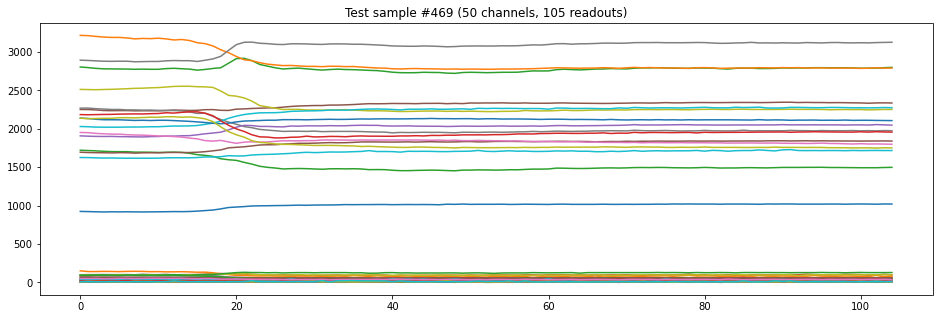

Time Frame Lengts: [105, 181, 256]
Test TimeFrame composition: {105: 286, 181: 285, 256: 284}


In [44]:
plot_test( pkl.load(open('Data/X_test_dataset_2.pkl', 'rb')))

В тестовых данных оси переставлены местами по сравнению с исходными, первая ось - каналы, вторая - время.

Организаторы заявили, что масштаб времени в тестовых данных может быть изменен. Вероятно, в некоторых случаях происходило прореживание данных, что приводит к видимому ускорению процессов. 

#### Submission файл

In [45]:
sample_subm = pd.read_csv('Data/sample_submission.csv', index_col=0)
print(sample_subm.shape) 
sample_subm.tail(10)

(471610, 1)


class
subject_id-sample-timestep       
3-860-171                       3
3-860-172                       2
3-860-173                       4
3-860-174                       2
3-860-175                       3
3-860-176                       3
3-860-177                       4
3-860-178                       4
3-860-179                       2
3-860-180                       1

In [46]:
sample_subm.head(10)

class
subject_id-sample-timestep       
1-0-0                           4
1-0-1                           2
1-0-2                           0
1-0-3                           0
1-0-4                           3
1-0-5                           1
1-0-6                           2
1-0-7                           4
1-0-8                           2
1-0-9                           4

###  Создание обучающих и тестовых наборов данных

Организаторы предоставили baseline, в котором набор обучающих данных подготавливается с помощью процедуры из пакета MNE. Алгоритм формирования следующий:
- формируется первая производная стимула и выделяются моменты времени подачи команд компьютером;
- в качестве обучающих признаков используется временное окно в исходных данных в границах `[-30 .. +45] отсчетов относительно момента команды;
- возможно, что момент времени подачи команды выражается в виде двух отсчетов, так как общая длина обучающего таймфрема равна 107 отсчетам;
- в качестве таргета используется временное окно в стимуле в тех же границах.

Для целей формирования MVP и реплицирования бейзлайна можно использовать тот же подход со следующими дополнениями:
- в данных Субъекта 2 данные, отмеченные признаком -1 будут отброщены;
- в исходных данных и тестовых данных количество каналов будет сокращено до 16 значимых; 
- в исходных данных и тестовых данных будет произведено масштабирование сигналов в значимых каналах в диапазон 0..1. 

Основная причина - список каналов под удаление и коэффиценты масштабирования будут рассчитываться на основе исходных данных. Нет смысла откладывать это на потом. 

In [47]:
# mount - сборка субъекта и измерительной системы 
# используется словарь в качестве аналога записей фиксированной структуры
mounts = {
    1 : {
        'path_raw' : './Data/X_train_1.npy',
        'path_stimul' : './Data/y_train_1.npy',
        'path_test_dataset' : './Data/X_test_dataset_1.pkl',
    },
    2 : {
        'path_raw' : './Data/X_train_2.npy',
        'path_stimul' : './Data/y_train_2.npy',
        'path_test_dataset' : './Data/X_test_dataset_2.pkl',
    },
    3 : {
        'path_raw' : './Data/X_train_3.npy',
        'path_stimul' : './Data/y_train_3.npy',
        'path_test_dataset' : './Data/X_test_dataset_3.pkl',
    }
}


In [48]:
for mount_name, mount in mounts.items():
    mount['raw'] = np.swapaxes(np.load(mount['path_raw']),0,1)  # смена местами оси времени и номеров каналов
    mount['stimul'] = np.load(mount['path_stimul'])
    with open(mount['path_test_dataset'], 'rb') as f:
        mount['test_dataset'] = pkl.load(f)
    print('Mount', mount_name, len(mount['test_dataset']))

Mount 1 899
Mount 2 855
Mount 3 861


#### Удаление плохих данных в сборке Субъекта 2

К сожалению, простое удаление отметок с отрицательным значением стимула не обеспечивает необходимого результата. В диапазоне 20053-20512 отмечены плохие значения. Если их удалить - остается переход из команды 4 в команду 3, что не соответствует условиям. Придется удалять данные в несколько более широком диапазоне, захватывающем еще два жеста. Границы удаления будут заданы вручную, из-за неоправданных затрат на составление кода удаления выбросов. 

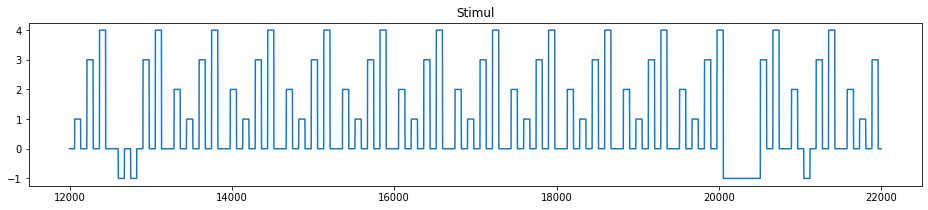

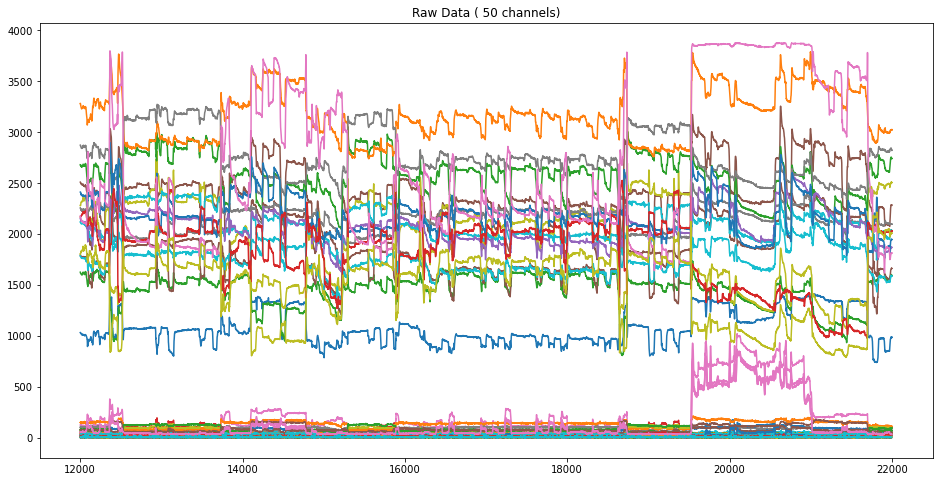

954 bad readouts


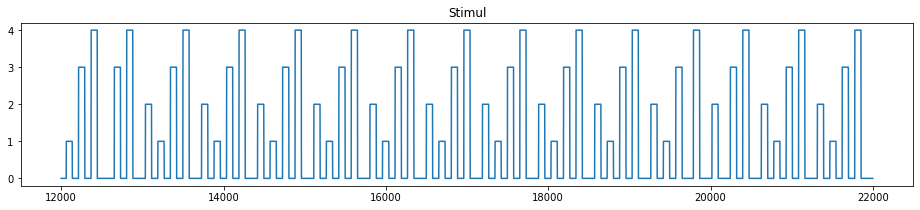

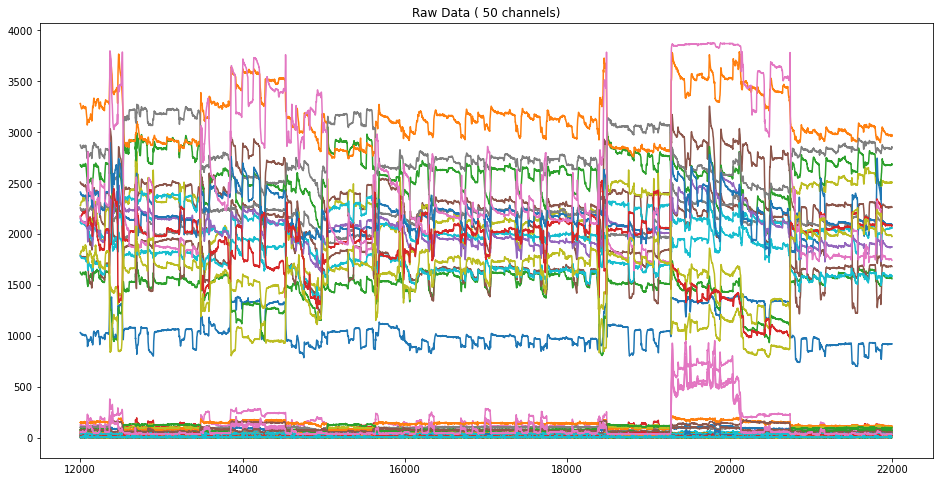

In [49]:
m = mounts[2] 
plot_train_target( m['raw'], m['stimul'], 12000, 22000)
# badreadouts = np.flatnonzero(m['stimul']<0)  
# простое удаление не сработало, из-за проблемной области 20053-20512
badreadouts = np.concatenate((np.arange(12600, 12850),
                             np.arange(19974, 20600),
                             np.arange(21045, 21123)))

print(len(list(badreadouts)),'bad readouts')
#data = np.delete(source, sens_delete, axis=0) #1 если каналы в оси 1
new_raw = np.delete(m['raw'],badreadouts,axis=1) 
# new_raw.shape
new_stimul = np.delete(m['stimul'],badreadouts,axis=0)
# new_stimul.shape
plot_train_target( new_raw, new_stimul, 12000, 22000)
m['raw'] = new_raw
m['stimul'] = new_stimul

Места удаления видны по изменениям регулярной структуры команд в канале стимула.  

#### Удаление незначимых каналов и масштабирование

In [50]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

Особенность обработки - масштабирование на всем наборе данных.  Исследование показало, что минимумы в каналах тестового набора меньше минимумов в исходных данных, благодая чему данные могут принимать отрицательные значения.  Пришлось конструировать искуственный набор данных и обучать MinMaxscaler на всех данных. В ходе обсуждения темы с организаторами они не смогли признать такую особенность данных и разрешить использовать обучение мин-макс нормализатора на всем корпусе данных.  

In [51]:
def minmax_scale(mounts):
    '''
    Масштабирование данных в наборе mount алгоритмом MinMaxScale
    возвращает словарь с масштабированными данными
    '''
    scaler = MinMaxScaler()

    for mount_name, mount in mounts.items():
        new_raw, sens_to_delete = delete_low_sens(mount['raw'], min_mean=MIN_MEAN)
        # new_raw.shape
        #mount['new_raw'], scale = scale_good_channels(new_raw)
        # собираю массив из всех наблюдений для настройки параметров MinMaxScaller
        test_array = np.delete( np.concatenate(tuple(mount['test_dataset']),axis=1), sens_to_delete, axis=0)
        full_array = np.concatenate( (new_raw, test_array),axis=1) 
        # обучаю на всем массиве
        scaler.fit(np.swapaxes(full_array,0,1))
        # масштабирую исходные данные
        mount['new_raw'] = np.swapaxes(scaler.transform(np.swapaxes(new_raw,0,1)),0,1)
        # масштабирую тестовые данные 
        new_test = []
        for t in mount['test_dataset']:
            new_test.append( np.swapaxes( scaler.transform( np.swapaxes(np.delete(t, sens_to_delete, axis=0),0,1)),0,1))
        mount['new_test'] = new_test
    
    return mounts



In [52]:
# Класс MaxScaler для нормализации входных данных вместо MinMaxScaler
# загрузка наследуемых классов из стандартной библиотеки sklearn
from sklearn.base import BaseEstimator, TransformerMixin
# загрузка стандартной функции проверки
from sklearn.utils.validation import check_is_fitted

class MaxScaler(BaseEstimator, TransformerMixin):
    # параметры класса именуются с окончанием _ в sklearn
    def fit(self, X):
        self.num_cols_ = X.shape[1]
        self.xmax_ = np.zeros(self.num_cols_)
        for i in range(self.num_cols_):
            self.xmax_[i] = X[:,i].max()
        return self
    
    def transform(self, X):
        # проверка осуществления подгонки
        check_is_fitted(self, 'num_cols_')
        # проверка совпадения количества столбцов 
        assert (X.shape[1] == self.num_cols_), 'Number of columns in fit and transform arrays does not match'
        # mX должен быть плавающим
        mX= np.zeros((X.shape[0], X.shape[1]))
        for i in range(self.num_cols_):
            xmax = self.xmax_[i] * 1.0
            if xmax != 0 : 
                mX[:,i] = X[:,i] / xmax

        return mX
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
       

In [162]:
def scaler_scale(scaler, mounts, window=1, fit_to_raw=True):
    '''
    Стандартизация данных в наборе mount алгоритомом scaler из пакета sklearn
    возвращает словарь со стандартизованными данными
    window - размер окна для EWMA сглаживания
    fit_to_raw - обучать на основе данных из исходного массива или исходного и тестовых массивов 
    '''
    # scaler = StandardScaler()

    for mount_name, mount in mounts.items():
        nr, sens_to_delete = delete_low_sens(mount['raw'], min_mean=MIN_MEAN)        
        # smooth_data = np.apply_along_axis(ewma, 1, scaled_data, src_w)
        new_raw = np.swapaxes(np.apply_along_axis(ewma, 1, nr, window),0,1)
        
        if fit_to_raw: 
            scaler.fit(new_raw) # np.swapaxes(new_raw,0,1))
        else:
            # собираю массив из тестов
            # Обычно масштабирование обучается только на учебной части, но в данном случае есть различия в маштабах данных
            # поэтому предусматриваю возможность обучить масштабирование на всем комплекте данных 
            test_array = np.swapaxes(np.delete( np.concatenate(tuple(mount['test_dataset']),axis=1), sens_to_delete, axis=0), 0,1)
            # print('New raw shape', new_raw.shape)
            # print('Test array shape', test_array.shape)
            full_array = np.concatenate( (new_raw, test_array),axis=0)
            # print('Full array shape', full_array.shape)
            scaler.fit(full_array) # np.swapaxes(new_raw,0,1))

        mount['new_raw'] = np.swapaxes(scaler.transform(new_raw),0,1)
        mount['sens_to_delete'] = sens_to_delete
        #print(mount['new_raw'][2,:])
        new_test = []
        for t in mount['test_dataset']:
            nt = np.swapaxes(np.apply_along_axis(ewma, 1, np.delete(t, sens_to_delete, axis=0), window),0,1)
            new_test.append( np.swapaxes( scaler.transform(nt),0,1))
        mount['new_test'] = new_test
    
    return mounts

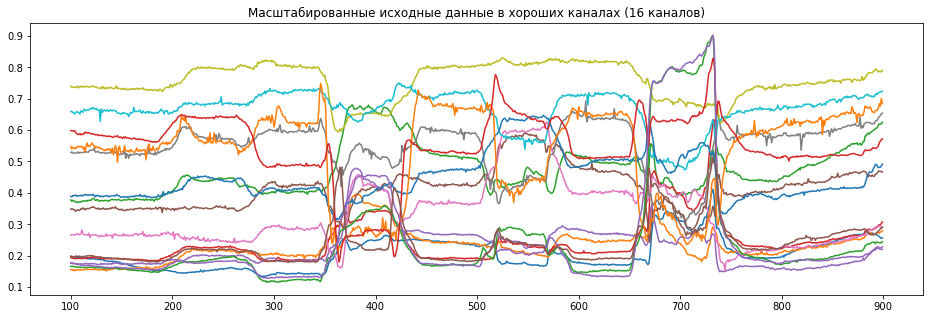

List of 899 timeframes


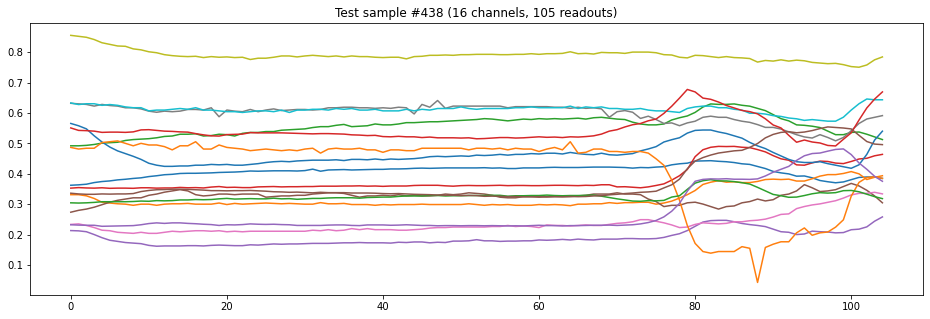

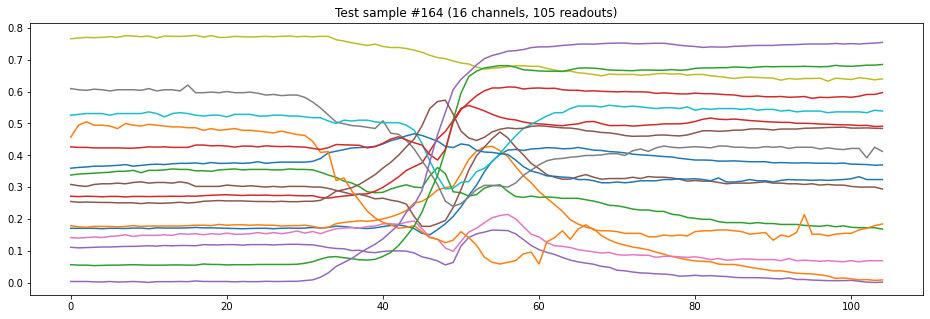

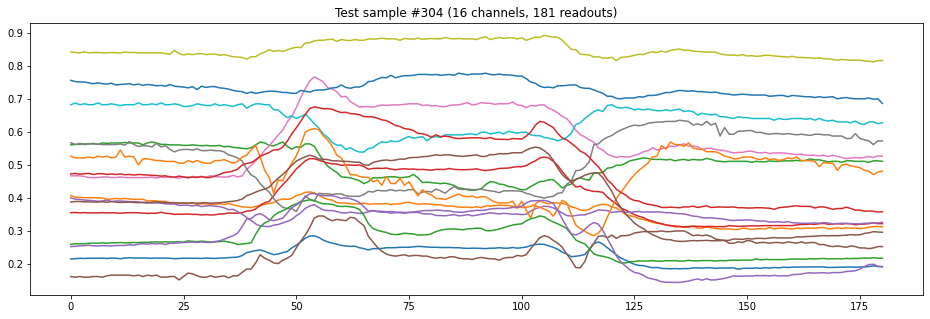

Time Frame Lengts: [105, 181, 256]
Test TimeFrame composition: {105: 303, 181: 299, 256: 297}


In [163]:
# mounts = minmax_scale(mounts)
mounts = scaler_scale(MinMaxScaler(), mounts, window=1, fit_to_raw=False) #StandardScaler()  MinMaxScaler()
plot_channels(mounts[1]['new_raw'], 100, 900, 'Масштабированные исходные данные в хороших каналах')
plot_test(mounts[1]['new_test'])

In [164]:

# Словарь структуры, аналогичной mounts, но для имен генерируемых наборов данных
# Можно чаще менять только имена файлов
#
#output_names = {
#    1 : {
#        'path_train'  : './Data/Train04_1.npy',
#        'path_target' : './Data/Target04_1.npy',
#        'path_env'    : './Data/Envel04_1.npy',
#        'path_test'   : './Data/Test04_1.pkl',
#    },
#    2 : {
#        'path_train'  : './Data/Train04_2.npy',
#        'path_target' : './Data/Target04_2.npy',
#        'path_env'    : './Data/Envel04_2.npy',
#        'path_test'   : './Data/Test04_2.pkl',
#    },
#    3 : {
#        'path_train'  : './Data/Train04_3.npy',
#        'path_target' : './Data/Target04_3.npy',
#        'path_env'    : './Data/Envel04_3.npy',
#        'path_test'   : './Data/Test04_3.pkl',
#    }
#}
SET_NUM = '09'
output_names = {}
for i in range(1,4):
    ons = {}
    ons['path_train'] = f'./Data/Train{SET_NUM}_{str(i)}.npy'
    ons['path_target'] = f'./Data/Target{SET_NUM}_{str(i)}.npy'
    ons['path_env'] = f'./Data/Envel{SET_NUM}_{str(i)}.npy'
    ons['path_test'] = f'./Data/Test{SET_NUM}_{str(i)}.pkl'
    output_names[i] = ons
print(output_names)

{1: {'path_train': './Data/Train09_1.npy', 'path_target': './Data/Target09_1.npy', 'path_env': './Data/Envel09_1.npy', 'path_test': './Data/Test09_1.pkl'}, 2: {'path_train': './Data/Train09_2.npy', 'path_target': './Data/Target09_2.npy', 'path_env': './Data/Envel09_2.npy', 'path_test': './Data/Test09_2.pkl'}, 3: {'path_train': './Data/Train09_3.npy', 'path_target': './Data/Target09_3.npy', 'path_env': './Data/Envel09_3.npy', 'path_test': './Data/Test09_3.pkl'}}


In [165]:
# Записываю новые тесты
for m in mounts.keys():
    # print(mount['path_test'])
    with open(output_names[m]['path_test'], 'wb') as f:
        pkl.dump(mounts[m]['new_test'],f)

#### Нарезка исходных данных на тайм-фреймы

In [57]:
from random import shuffle 

In [58]:
def find_comand_moments(mounts):
    '''
    Формирование списка моментов подачи команд компьютером человеку для данных в mounts
    moments записываются в mounts
    '''
    for mname, mount in mounts.items():
        print('Subject/mount #', mname)
        raw_moments = list(np.flatnonzero(np.abs(np.diff(mount['stimul']))))
        moments = [raw_moments[0]]
        # если промежуток между соседними отсчетами большой (больше 100) то добавляю два пустых отсчета для балансировки 
        # обучающего набора за счет команд открытая ладонь - открытая ладонь
        for pos in range(1,len(raw_moments)):
        # print( raw_moments[pos-1], raw_moments[pos] )
            if raw_moments[pos] - raw_moments[pos-1] > 100 :
                moments.append(raw_moments[pos]-85)
                moments.append(raw_moments[pos]-70)
        
            moments.append(raw_moments[pos]) 

        print('Number of stimul comands', len(raw_moments))
        print('Number of train frames', len(moments))
        mount['moments'] = moments

    return mounts


In [115]:
def adjust_human_reaction(data, before, after):
    '''
    корректировка моментов подачи команд компьютером человеку на время реакции человека
    data дополняется новым набором моментов реакции на команду
    moments - моменты подачи команды компьютером, используются для таргета
    adjusted moments - моменты отработки команды человеком, используются для трейна 
    before - левая граница окна для поиска пика огибающей
    after - правая граница окна для поиска пика огибающей
    '''
    for mnt in data.values():
        moments = mnt['moments']
        # print(moments)
        # print('Length moments', len(moments))
        adj_moments = [] # mount['moments'].copy()
        stimul = mnt['stimul']
        # переиспользую функцию, разработанную на этапе анализа
        _d, smooth_env, _a, _b = calc_smooth_env(mnt['raw'], MIN_MEAN, SRC_WINDOW, ENV_WINDOW, LOW_LIMIT)
        mnt['envelope'] = smooth_env
        maxpos = smooth_env.shape[0]
        maxcmd = len(moments)
        for curr_mom in moments:
            # curr_mom = moments[i]
            left = stimul[curr_mom-1]
            right = stimul[curr_mom+1]
            # if i == 0 : print(curr_mom,left,right )
            if left != right :
                pl = curr_mom - before
                pr = ((curr_mom + after) if i < maxcmd-1 else maxpos) 
                frame = smooth_env[pl:pr]
                act_val = frame.max()
                act_delay = np.argmax(frame)
                act_pos = pl + act_delay
                # if i == 0: print(pl, pr, act_val, act_delay, act_pos) 
                adj_moments.append(act_pos)
            else:
                adj_moments.append(curr_mom)
        #print('Length adjusted moments', len(adj_moments))
        #print(moments[0], adj_moments[0])
        #print(stimul[moments[0]-1], stimul[moments[0]+1])
        mnt['adjusted moments'] = adj_moments
    return data

In [141]:
def cut_save_train_target(mounts, names, before, after, step=1):
    '''
    Нарезка и сохранение данных 
    mounts - исходные данные
    names - имена файлов для сохранения данных
    before - опережение начала таймфрейма относительно момента подачи команды 
    after - задержка окончания таймфрейма относительно момента подачи команды
    step - шаг сохранение данных
    '''
    for m in mounts.keys():
        mount = mounts[m]
        out_names = names[m] 
        # нарезаем исходный массив на кусочки
        stimul = mounts[m]['stimul']
        new_raw = mounts[m]['new_raw']
        env = mounts[m]['envelope']
        max_readout = stimul.shape[0]

        train = list()
        target = list()
        envs = list()
        moments = mounts[m]['moments']
        adj_moments = mounts[m]['adjusted moments']
        for i in range(len(moments)):
            mo = moments[i]
            mol, mor = mo-before, mo+after 
            am = adj_moments[i]
            aml, amr = am-before, am+after
            #print(mo,am)
            if mor > max_readout : continue
            if amr > max_readout: continue
            #print(mo-before, mo, mo+after, am-before, am, am+after,)
            train.append(new_raw[:,aml:amr:step])
            target.append(stimul[mol:mor:step])
            envs.append(env[aml:amr:step])

        new_train = np.stack(train,axis=0)
        new_target = np.stack(target, axis=0)
        new_env = np.stack(envs, axis=0)
        #print('Train:',new_train.shape)
        #print('Target:', new_target.shape)
    
        # Сортировка данных
        # train_target = np.concatenate(( np.expand_dims(new_target,1), 
        #                                np.expand_dims(new_env,1),
        #                                new_train), axis=1)
        # print(train_target.shape)
        # train_target=np.random.Generator.permutation(train_target)
        # print(train_target.shape)
    
        # new_train = train_target[:,2:,:]
        # new_target = train_target[:,0,:]
        # new_env = train_target[:,1,:]
        print(f'Train {m}: {new_train.shape}')
        print(f'Target {m}: {new_target.shape}')
        print(f'Envelope {m}: {new_env.shape}')
        # Сохранение данных
        np.save(out_names['path_train'],new_train)
        np.save(out_names['path_target'], new_target)
        np.save(out_names['path_env'], new_env)

In [166]:

#BEFORE = 30 #readouts
#AFTER = 60 #readouts
#STEP = 1 #readout for speedup of data
show_charts = False
k = 3
mounts = find_comand_moments(mounts)
print(mounts[k]['moments'][0])
mounts = adjust_human_reaction(mounts, before=10, after=45)
# проверка выделения релевантного куска данных и его центрирования
if show_charts : 
    stimul = mounts[k]['stimul']
    new_raw = mounts[k]['new_raw']
    env = mounts[k]['envelope']
    print('Original data')
    plot_three_lines(stimul, new_raw , env , 150, 250, 'Target', 'Train', 'Огибающая')
    mo, am = mounts[k]['moments'][0], mounts[k]['adjusted moments'][0]
    print('Sliced Data:', mo, am)
    mol, mor = mo-45, mo+45
    aml, amr = am-45, am+45
    stimul_slice = stimul[mol:mor]
    raw_slice = new_raw[:,aml:amr]
    env_slice = env[aml:amr]
    plot_three_lines(stimul_slice, raw_slice , env_slice , 0, 90, 'Target', 'Train', 'Огибающая')

# Нарезка и сохранение данных
cut_save_train_target(mounts, output_names, before = 45, after = 45, step =2)
# Проверка нарезки

m = 3 #mount
s = 0 #sample
if show_charts : 
    train = np.load(output_names[m]['path_train'])
    print('Generated train shape',train.shape)
    targ  = np.load(output_names[m]['path_target'])
    print('Generated target shape', targ.shape)
    env = np.load(output_names[m]['path_env'])
    print('Generated envelope shape', env.shape)

    # plot_train_target( train[s], targ[s], 0, targ.shape[-1])
    plot_three_lines(targ[s], train[s] , env[s], 0, targ.shape[-1], 'Target', 'Train', 'Огибающая')


Subject/mount # 1
Number of stimul comands 277
Number of train frames 345
Subject/mount # 2
Number of stimul comands 254
Number of train frames 322
Subject/mount # 3
Number of stimul comands 268
Number of train frames 334
178
Train 1: (344, 16, 45)
Target 1: (344, 45)
Envelope 1: (344, 45)
Train 2: (321, 16, 45)
Target 2: (321, 45)
Envelope 2: (321, 45)
Train 3: (333, 16, 45)
Target 3: (333, 45)
Envelope 3: (333, 45)
